In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import numpy as np
import os
pd.options.display.float_format = '{:.2f}'.format
import math
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.stats.sandwich_covariance as sw

from plotnine import *
import statsmodels.formula.api as smf
from arch.unitroot import PhillipsPerron
from stargazer.stargazer import Stargazer


In [2]:
# Carregar o arquivo Excel
df = pd.read_excel("DataFrame_Valores.xlsx")
df

,Ano,Freguesia,Preço_m2,N_AL,N_H,N_D,PIB_AML,IDE_CI_GL,perc_Juro
0,2007,Ajuda,1941.00,0.00,8957.00,0.00,65807.06,1271.04,4.82
1,2008,Ajuda,1785.25,0.00,8937.50,0.00,67581.69,1285.38,3.37
2,2009,Ajuda,2099.30,0.00,8918.00,0.00,66436.60,1651.43,1.00
3,2010,Ajuda,2030.13,0.00,8898.50,0.00,67732.97,1880.53,1.25
4,2011,Ajuda,1681.89,0.00,8879.00,0.00,66343.85,2013.33,1.67
...,...,...,...,...,...,...,...,...,...
403,2019,São Vicente,3735.44,1662.00,10202.60,0.00,77439.68,6128.30,-0.34
404,2020,São Vicente,3797.13,1631.00,10189.30,0.00,71642.26,6329.82,-0.52
405,2021,São Vicente,3926.75,1614.00,10176.00,0.00,76602.81,7171.80,-0.55
406,2022,São Vicente,4241.94,1607.00,10162.70,133.34,87368.25,7782.02,2.57


In [3]:
# Definindo as agregações por coluna
aggregations = {
    'Preço_m2': 'mean',  
    'N_AL': 'sum',  
    'N_H': 'sum',
    'N_D': 'sum',
    'PIB_AML': 'mean',  
    'IDE_CI_GL': 'mean',
    'perc_Juro': 'mean'
}

# Aplicando o groupby com as agregações especificadas
df = df.groupby('Ano').agg(aggregations)
df = df.reset_index()

# Colocar a coluna 'Anos' como a primeira coluna
df['Anos'] = range(0, len(df))
df.insert(0, 'Anos', df.pop('Anos'))

df

,Anos,Ano,Preço_m2,N_AL,N_H,N_D,PIB_AML,IDE_CI_GL,perc_Juro
0,0,2007,2215.50,10.70,307534.60,6076.79,65807.06,1271.04,4.82
1,1,2008,2123.53,21.40,311646.20,5588.03,67581.69,1285.38,3.37
2,2,2009,2175.61,53.50,315757.80,5772.33,66436.60,1651.43,1.00
3,3,2010,2038.49,107.00,319869.40,6252.49,67732.97,1880.53,1.25
4,4,2011,1872.16,137.00,323981.00,6355.06,66343.85,2013.33,1.67
5,5,2012,1699.70,227.00,323597.20,6789.17,62528.74,2034.74,0.32
6,6,2013,1714.31,420.00,323213.40,7310.29,62955.03,2631.61,0.37
7,7,2014,1841.89,1077.00,322829.60,8918.44,63145.81,3434.55,0.18
8,8,2015,2061.18,3213.00,322445.80,10099.85,64897.10,4077.88,-0.04
9,9,2016,2361.65,6367.00,322062.00,11066.13,66942.30,4180.46,-0.22


In [4]:
# Dados fornecidos na tabela para Lisboa
data = {
    "Ano": [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
            2017, 2018, 2019, 2020, 2021, 2022, 2023],
    "Valor (€)": [2279, 2230, 2119, 2182, 1860, 1715, 1812, 1933, 2079, 2300,
                  2899, 3447, 3763, 3827, 4172, 4498, 4946]
}

# Criando um DataFrame a partir dos dados
df_values_Confidencial_Imobiliário = pd.DataFrame(data)

# Supondo que df é o DataFrame existente que você possui
# Substituir a coluna 'Preço/m2' pelos novos valores
df['Preço_m2'] = df_values_Confidencial_Imobiliário['Valor (€)']

# Convert all columns to integers 64-bits except the "Taxa de Juro" column (note that int has a maximum value of 2,147,483,647)
cols_to_convert = df.columns.difference(['perc_Juro'])
df[cols_to_convert] = df[cols_to_convert].apply(lambda x: x.astype('int64'))
df

,Anos,Ano,Preço_m2,N_AL,N_H,N_D,PIB_AML,IDE_CI_GL,perc_Juro
0,0,2007,2279,10,307534,6076,65807,1271,4.82
1,1,2008,2230,21,311646,5588,67581,1285,3.37
2,2,2009,2119,53,315757,5772,66436,1651,1.00
3,3,2010,2182,107,319869,6252,67732,1880,1.25
4,4,2011,1860,137,323981,6355,66343,2013,1.67
5,5,2012,1715,227,323597,6789,62528,2034,0.32
6,6,2013,1812,420,323213,7310,62955,2631,0.37
7,7,2014,1933,1077,322829,8918,63145,3434,0.18
8,8,2015,2079,3213,322445,10099,64897,4077,-0.04
9,9,2016,2300,6367,322062,11066,66942,4180,-0.22


## Novas Variáveis

In [5]:
df['perc_AL_H'] = (df['N_AL']/df['N_H'])*100

df.loc[df['Ano'] > 2011, 'perc_AL_H'] = (df['N_AL']/(df['N_H']+df['N_AL']))*100

df['log_Preço_m2'] = np.log(df['Preço_m2'])

df['log_N_AL'] = np.log(df['N_AL'])

df

,Anos,Ano,Preço_m2,N_AL,N_H,N_D,PIB_AML,IDE_CI_GL,perc_Juro,perc_AL_H,log_Preço_m2,log_N_AL
0,0,2007,2279,10,307534,6076,65807,1271,4.82,0.00,7.73,2.30
1,1,2008,2230,21,311646,5588,67581,1285,3.37,0.01,7.71,3.04
2,2,2009,2119,53,315757,5772,66436,1651,1.00,0.02,7.66,3.97
3,3,2010,2182,107,319869,6252,67732,1880,1.25,0.03,7.69,4.67
4,4,2011,1860,137,323981,6355,66343,2013,1.67,0.04,7.53,4.92
5,5,2012,1715,227,323597,6789,62528,2034,0.32,0.07,7.45,5.42
6,6,2013,1812,420,323213,7310,62955,2631,0.37,0.13,7.50,6.04
7,7,2014,1933,1077,322829,8918,63145,3434,0.18,0.33,7.57,6.98
8,8,2015,2079,3213,322445,10099,64897,4077,-0.04,0.99,7.64,8.07
9,9,2016,2300,6367,322062,11066,66942,4180,-0.22,1.94,7.74,8.76


## Gráficos das variáveis

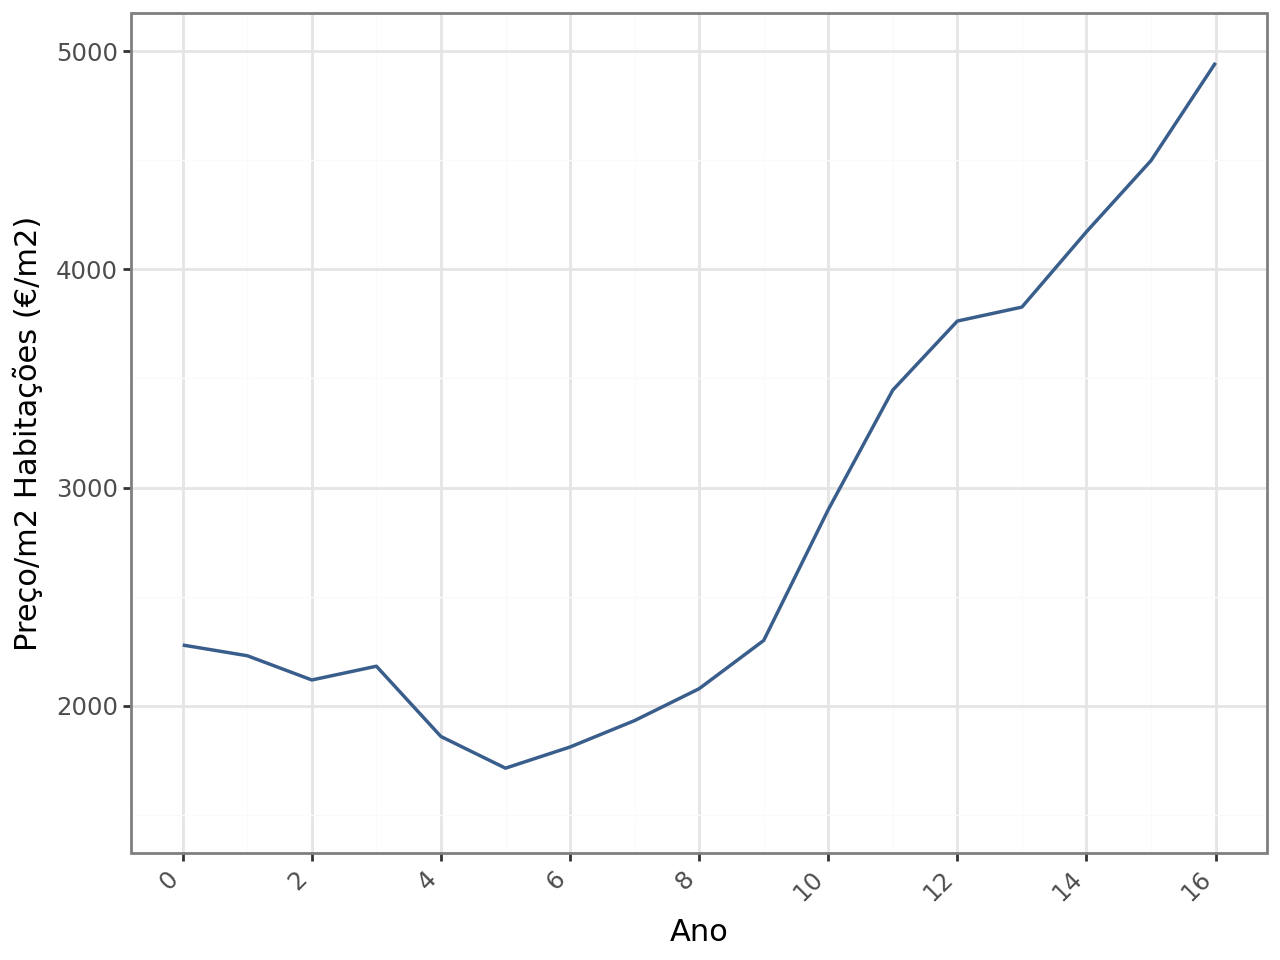

In [6]:
g1 = (
    ggplot(data=df)
    + geom_line(aes(x="Anos", y="Preço_m2"), colour="#3a5e8cFF", size=0.7)
    + labs(x="Ano", y="Preço/m2 Habitações (€/m2)")
    + scale_y_continuous(limits=[1500, 5000], breaks=[2000, 3000, 4000, 5000])
    + scale_x_continuous(breaks=[0,2,4,6,8,10,12,14,16])
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
g1

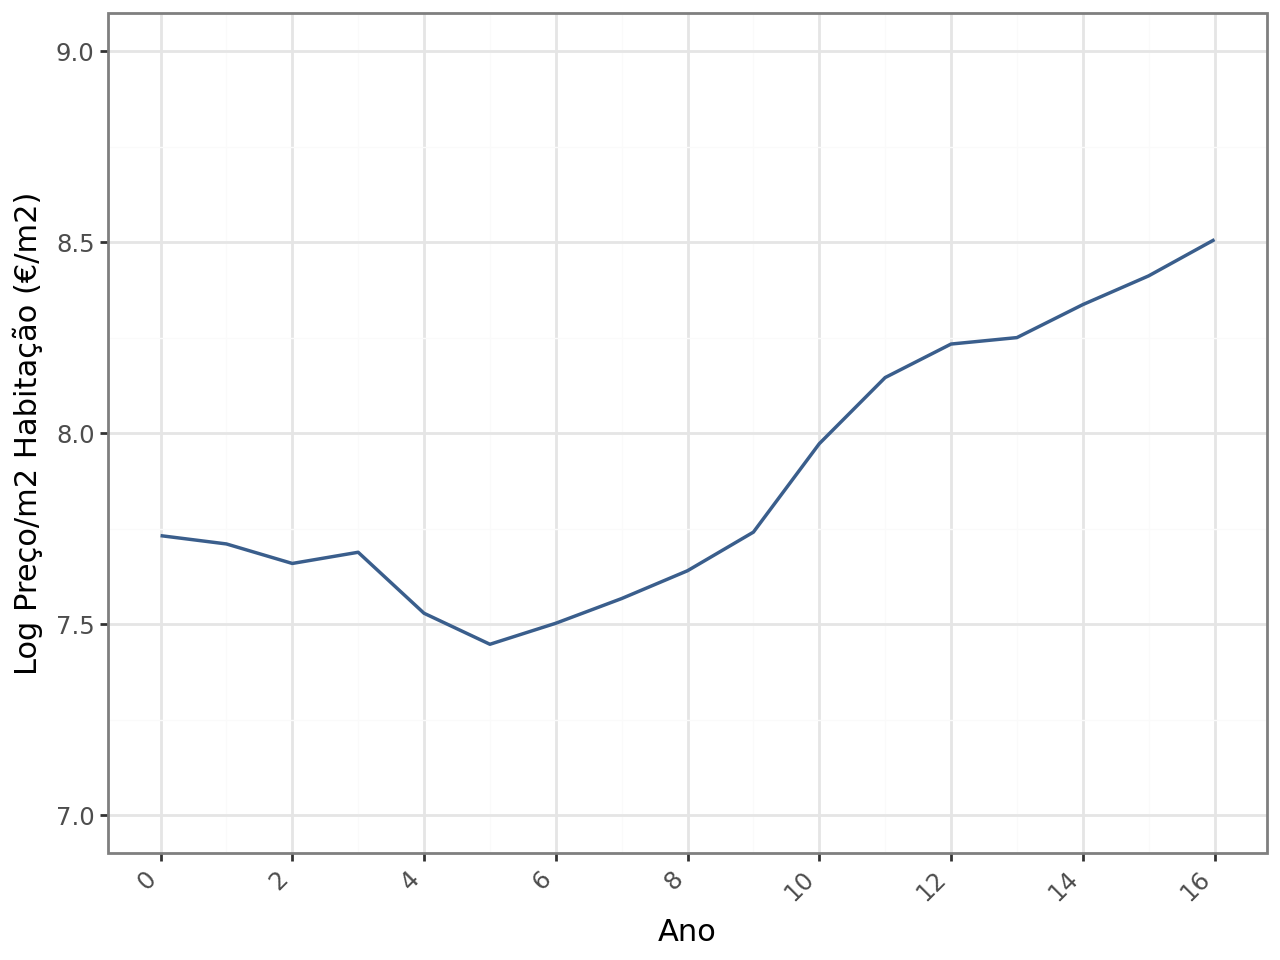

In [7]:
g1 = (
    ggplot(data=df)
    + geom_line(aes(x="Anos", y="log_Preço_m2"), colour="#3a5e8cFF", size=0.7)
    + labs(x="Ano", y="Log Preço/m2 Habitação (€/m2)")
    + scale_y_continuous(limits=[7, 9], breaks=[7, 7.5, 8, 8.5, 9])
    + scale_x_continuous(breaks=[0,2,4,6,8,10,12,14,16])
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
g1

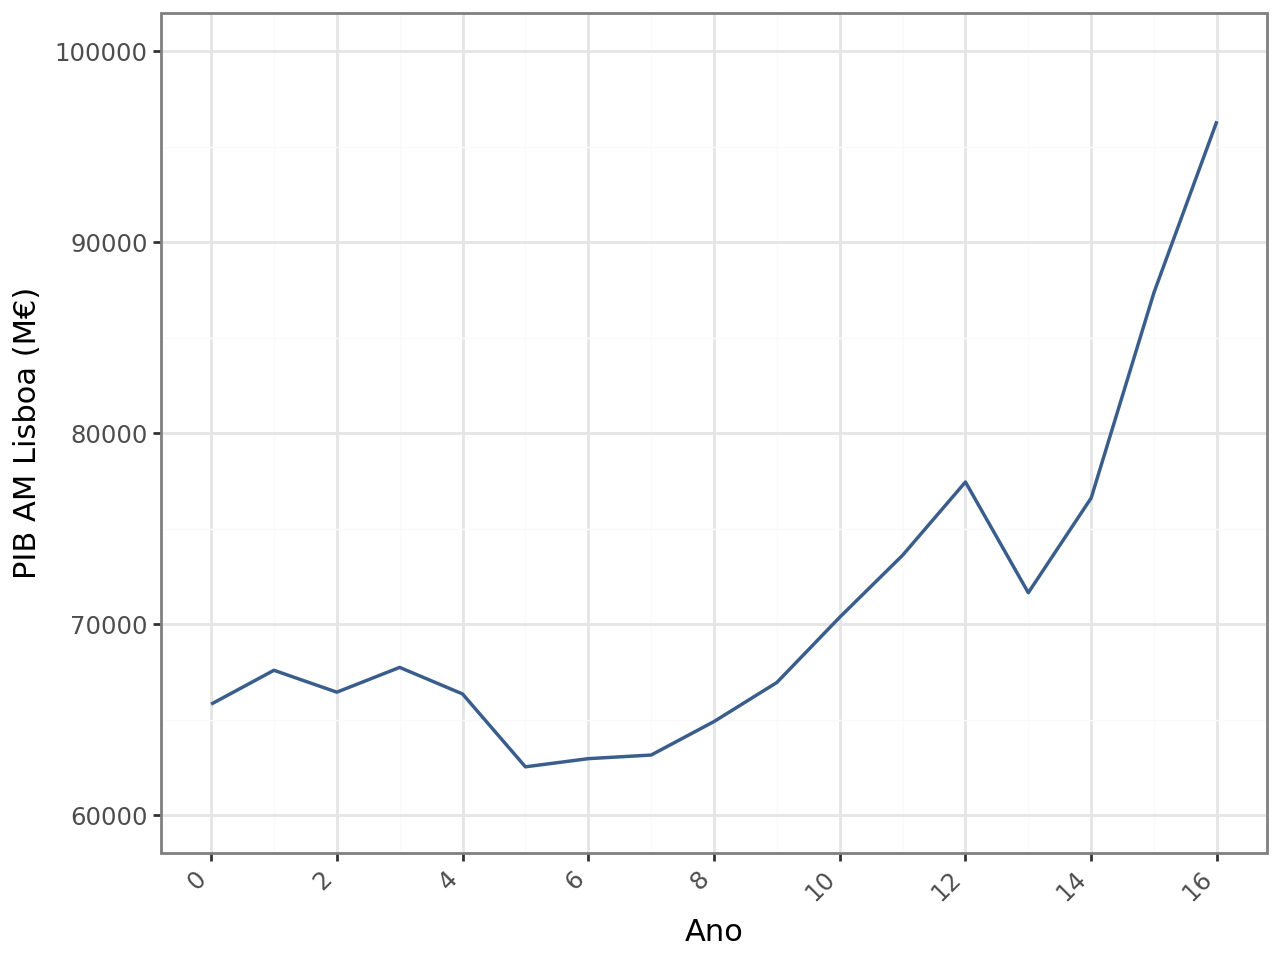

In [8]:
g1 = (
    ggplot(data=df)
    + geom_line(aes(x="Anos", y="PIB_AML"), colour="#3a5e8cFF", size=0.7)
    + labs(x="Ano", y="PIB AM Lisboa (M€)")
    + scale_y_continuous(limits=[6E4, 10E4], breaks=[6E4, 7E4, 8E4, 9E4, 10E4])
    + scale_x_continuous(breaks=[0,2,4,6,8,10,12,14,16])
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
g1

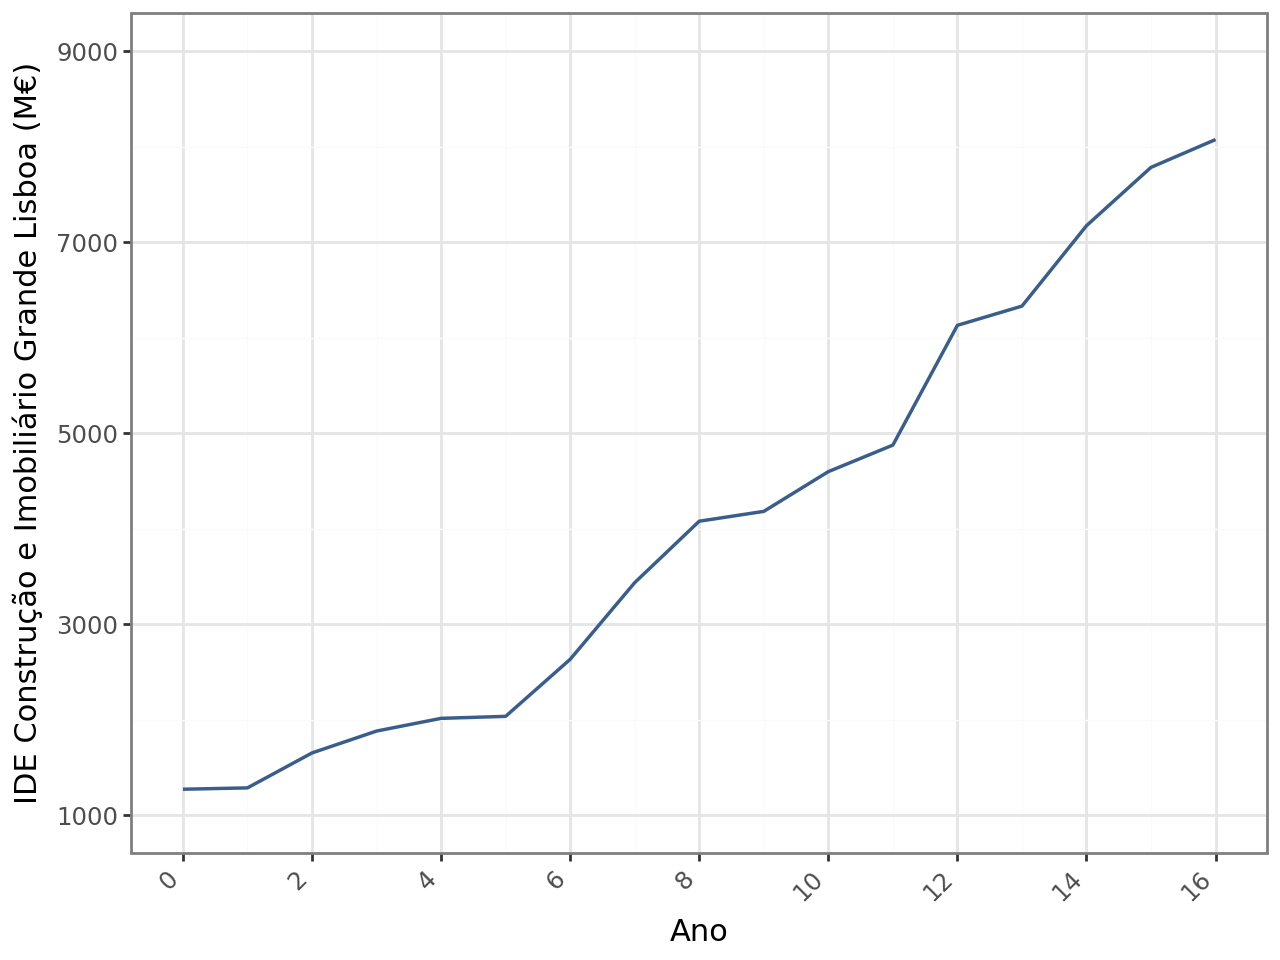

In [9]:
g1 = (
    ggplot(data=df)
    + geom_line(aes(x="Anos", y="IDE_CI_GL"), colour="#3a5e8cFF", size=0.7)
    + labs(x="Ano", y="IDE Construção e Imobiliário Grande Lisboa (M€)")
    + scale_y_continuous(limits=[1000, 9000], breaks=[1000, 3000, 5000, 7000, 9000])
    + scale_x_continuous(breaks=[0,2,4,6,8,10,12,14,16])
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
g1

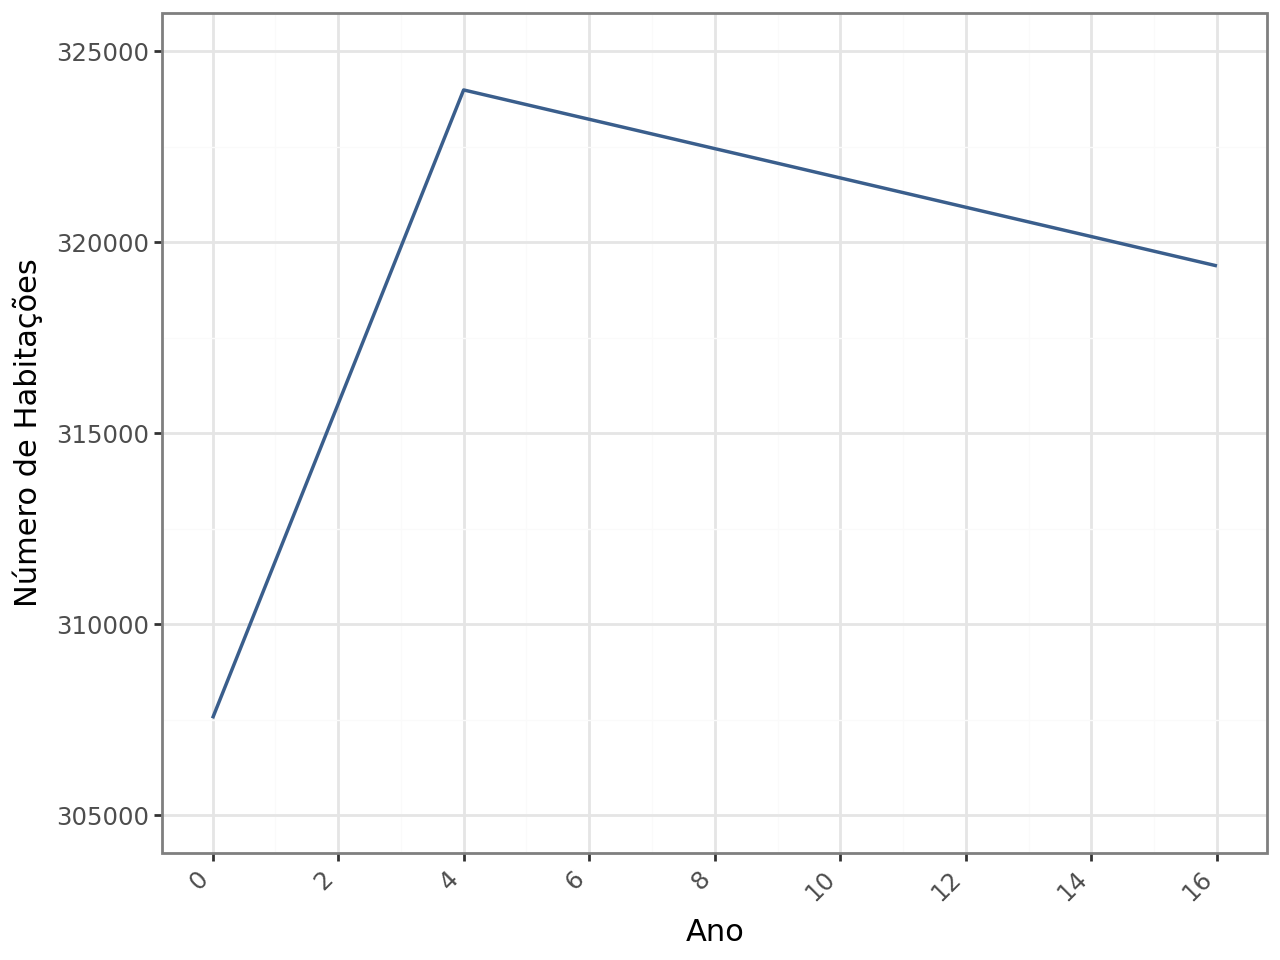

In [10]:
g1 = (
    ggplot(data=df)
    + geom_line(aes(x="Anos", y="N_H"), colour="#3a5e8cFF", size=0.7)
    + labs(x="Ano", y="Número de Habitações")
    + scale_y_continuous(limits=[305000, 325000], breaks=[305000, 310000, 315000, 320000, 325000])
    + scale_x_continuous(breaks=[0,2,4,6,8,10,12,14,16])
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
g1

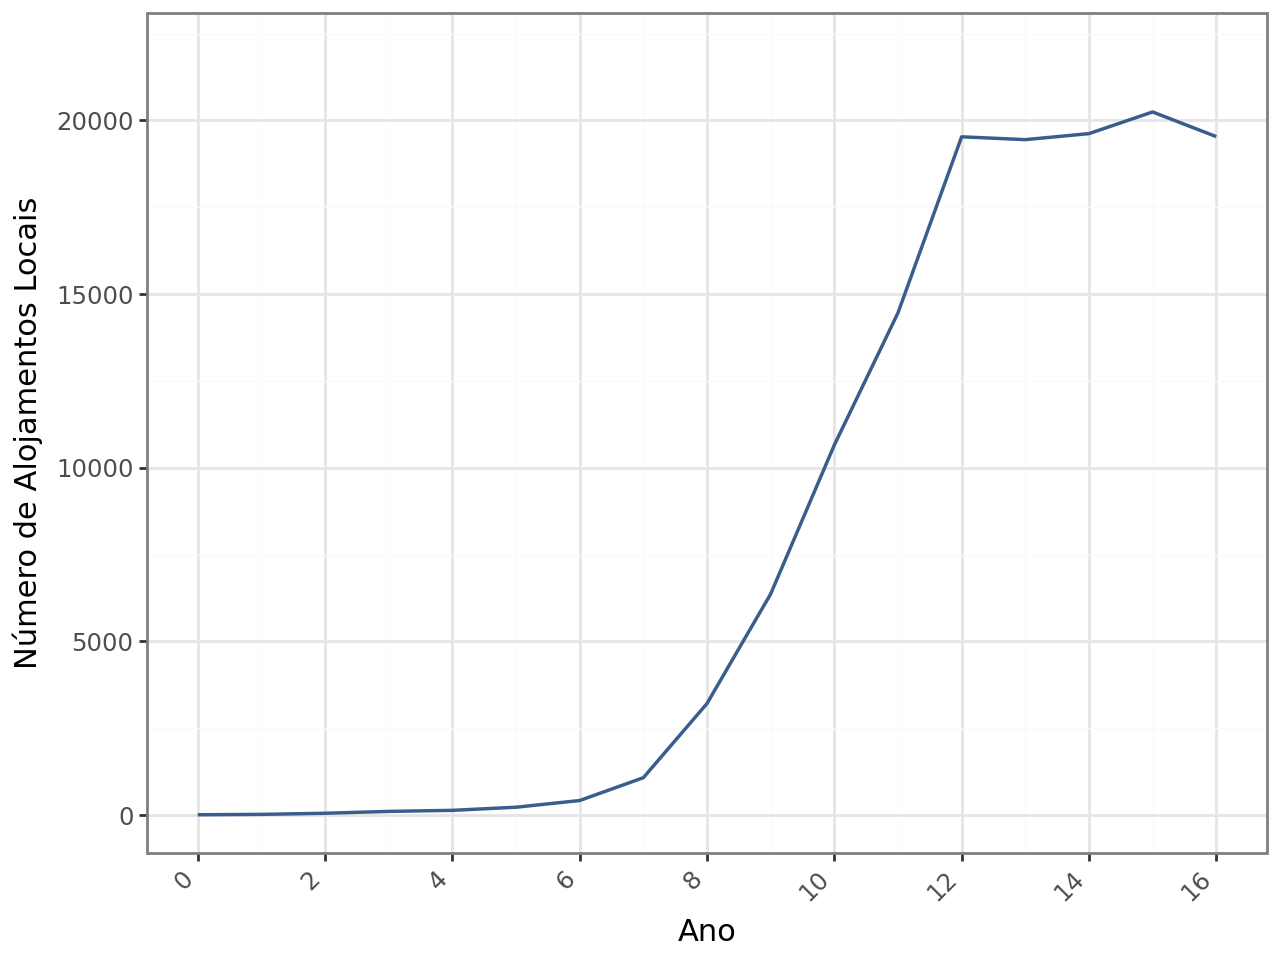

In [11]:
g1 = (
    ggplot(data=df)
    + geom_line(aes(x="Anos", y="N_AL"), colour="#3a5e8cFF", size=0.7)
    + labs(x="Ano", y="Número de Alojamentos Locais")
    + scale_y_continuous(limits=[0, 22000], breaks=[0, 5000, 10000, 15000, 20000])
    + scale_x_continuous(breaks=[0,2,4,6,8,10,12,14,16])
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
g1

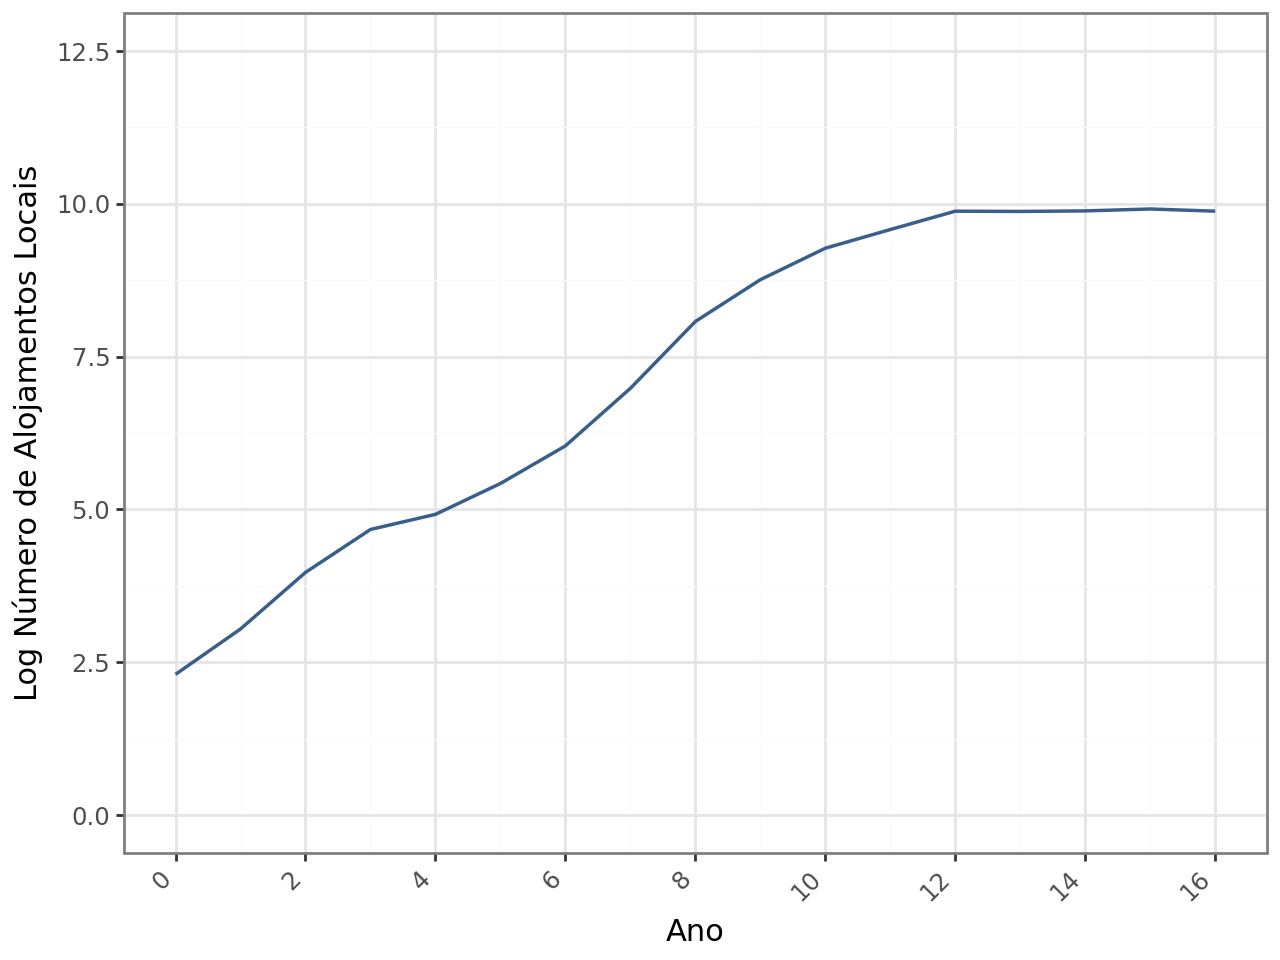

In [12]:
g1 = (
    ggplot(data=df)
    + geom_line(aes(x="Anos", y="log_N_AL"), colour="#3a5e8cFF", size=0.7)
    + labs(x="Ano", y="Log Número de Alojamentos Locais")
    + scale_y_continuous(limits=[0, 12.5], breaks=[0, 2.5, 5, 7.5, 10, 12.5])
    + scale_x_continuous(breaks=[0,2,4,6,8,10,12,14,16])
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
g1

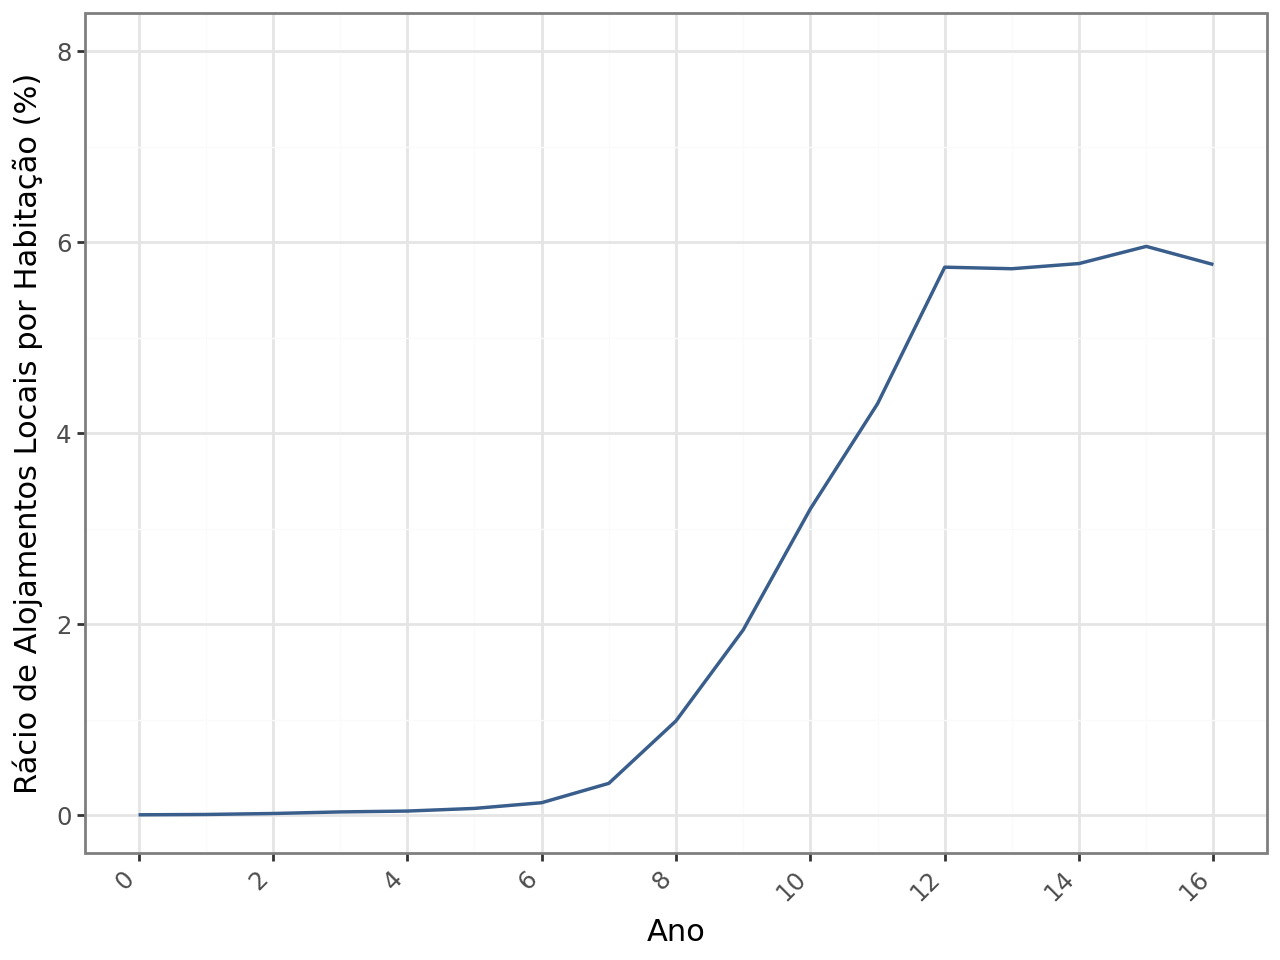

In [13]:
g1 = (
    ggplot(data=df)
    + geom_line(aes(x="Anos", y="perc_AL_H"), colour="#3a5e8cFF", size=0.7)
    + labs(x="Ano", y="Rácio de Alojamentos Locais por Habitação (%)")
    + scale_y_continuous(limits=[0, 8], breaks=[0, 2, 4, 6, 8])
    + scale_x_continuous(breaks=[0,2,4,6,8,10,12,14,16])
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
g1

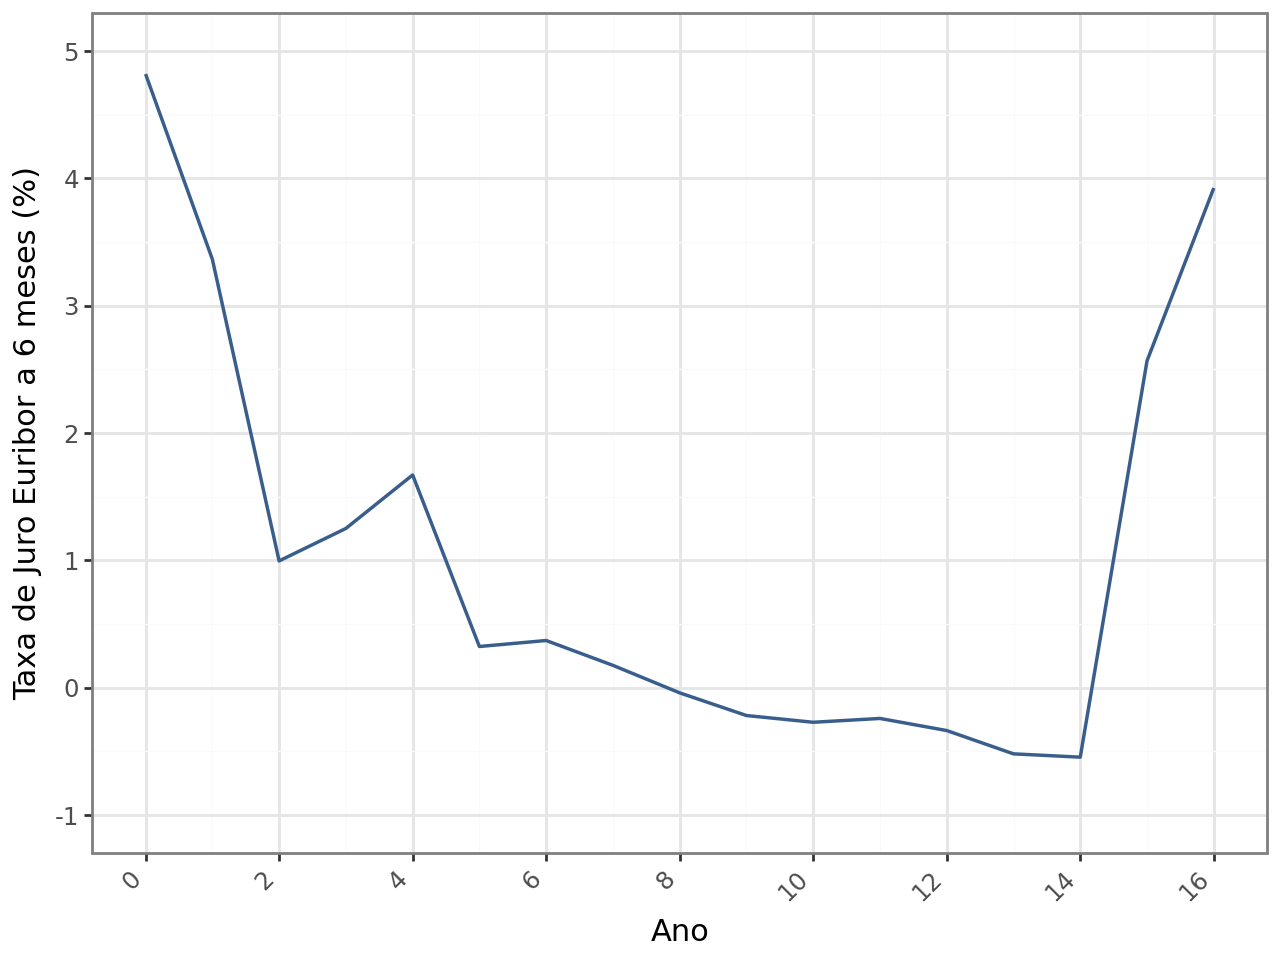

In [14]:
g1 = (
    ggplot(data=df)
    + geom_line(aes(x="Anos", y="perc_Juro"), colour="#3a5e8cFF", size=0.7)
    + labs(x="Ano", y="Taxa de Juro Euribor a 6 meses (%)")
    + scale_y_continuous(limits=[-1, 5], breaks=[-1, 0, 1, 2, 3, 4, 5])
    + scale_x_continuous(breaks=[0,2,4,6,8,10,12,14,16])
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
g1

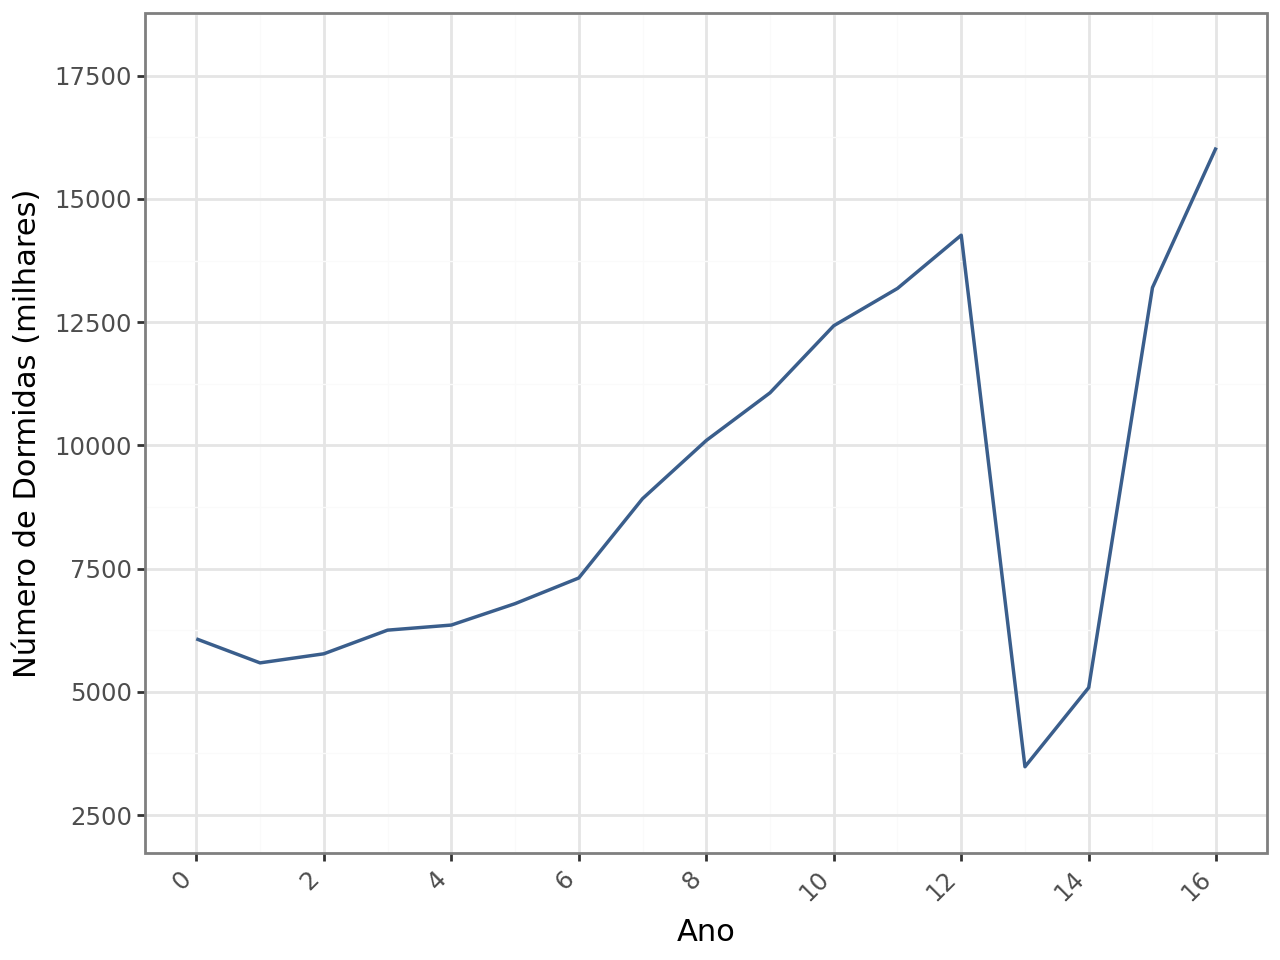

In [15]:
g1 = (
    ggplot(data=df)
    + geom_line(aes(x="Anos", y="N_D"), colour="#3a5e8cFF", size=0.7)
    + labs(x="Ano", y="Número de Dormidas (milhares)")
    + scale_y_continuous(limits=[2500, 18000], breaks=[2500, 5000, 7500, 10000, 12500, 15000, 17500])
    + scale_x_continuous(breaks=[0,2,4,6,8,10,12,14,16])
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
g1

# 6. Verificar Tipo de tendencia

### Modelo Linear

Regressão Linear para 'PREÇO_M2':
                            OLS Regression Results                            
Dep. Variable:               Preço_m2   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     42.06
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           1.03e-05
Time:                        00:13:10   Log-Likelihood:                -130.57
No. Observations:                  17   AIC:                             265.1
Df Residuals:                      15   BIC:                             266.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.582e

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17


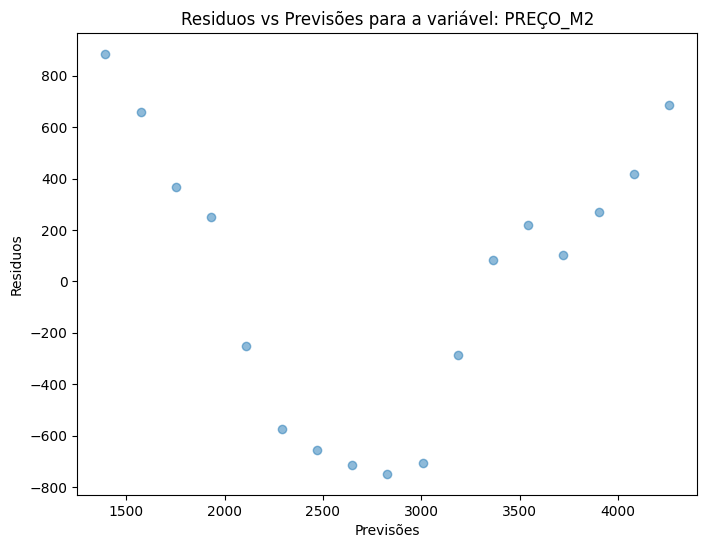

Regressão Linear para 'N_AL':
                            OLS Regression Results                            
Dep. Variable:                   N_AL   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     90.39
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           9.67e-08
Time:                        00:13:10   Log-Likelihood:                -161.42
No. Observations:                  17   AIC:                             326.8
Df Residuals:                      15   BIC:                             328.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.241e+06 

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17


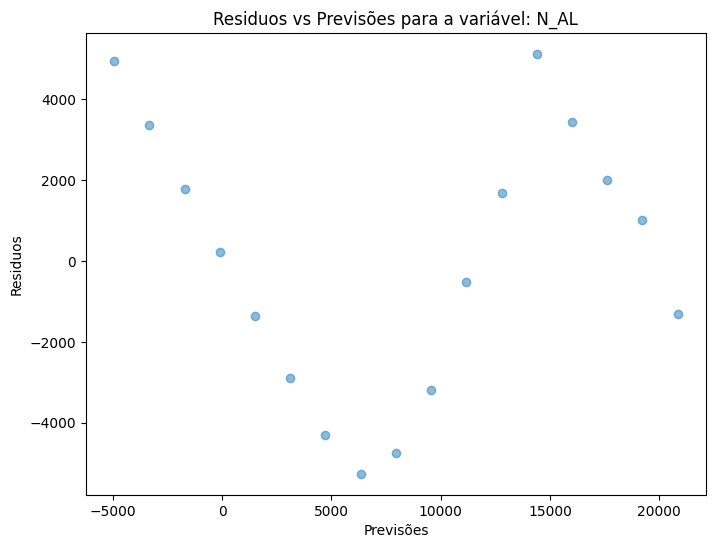

Regressão Linear para 'N_H':
                            OLS Regression Results                            
Dep. Variable:                    N_H   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     3.755
Date:                Mon, 05 Aug 2024   Prob (F-statistic):             0.0717
Time:                        00:13:10   Log-Likelihood:                -164.22
No. Observations:                  17   AIC:                             332.4
Df Residuals:                      15   BIC:                             334.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -4.61e+05  

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17


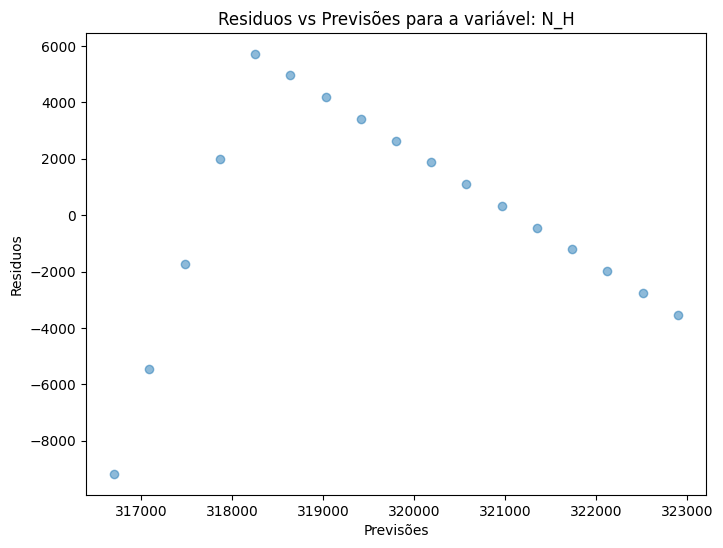

Regressão Linear para 'N_D':
                            OLS Regression Results                            
Dep. Variable:                    N_D   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     7.767
Date:                Mon, 05 Aug 2024   Prob (F-statistic):             0.0138
Time:                        00:13:11   Log-Likelihood:                -160.08
No. Observations:                  17   AIC:                             324.2
Df Residuals:                      15   BIC:                             325.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.714e+05  

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17


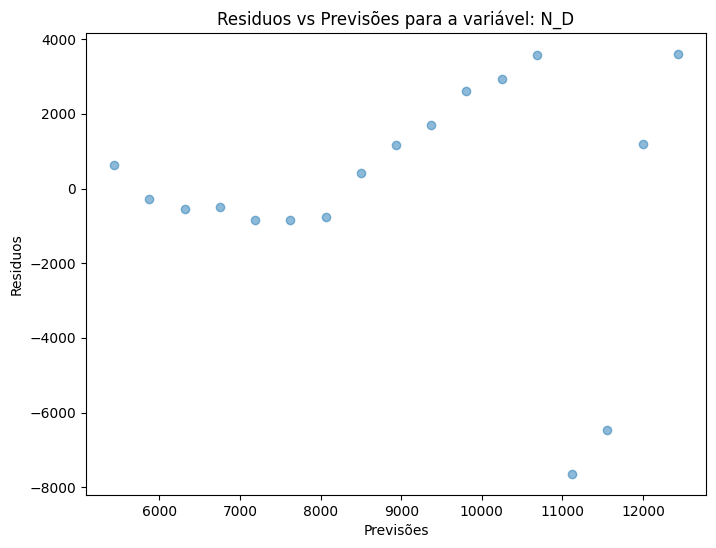

Regressão Linear para 'PIB_AML':
                            OLS Regression Results                            
Dep. Variable:                PIB_AML   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     20.31
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           0.000418
Time:                        00:13:11   Log-Likelihood:                -171.36
No. Observations:                  17   AIC:                             346.7
Df Residuals:                      15   BIC:                             348.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.692e+

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17


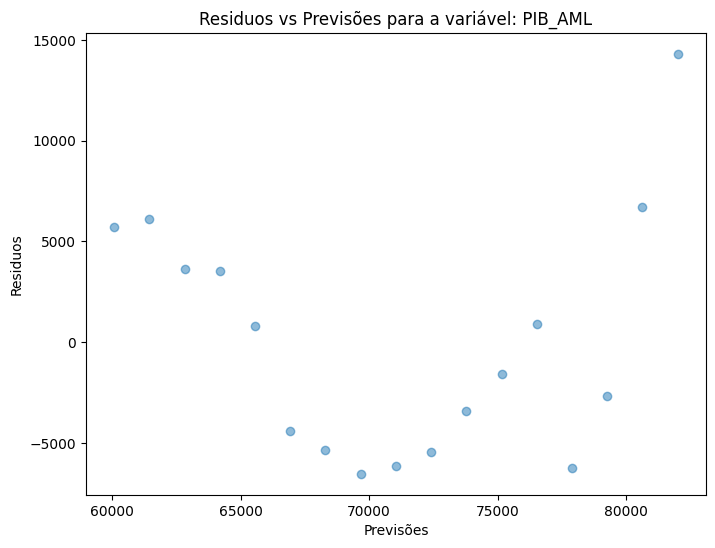

Regressão Linear para 'IDE_CI_GL':
                            OLS Regression Results                            
Dep. Variable:              IDE_CI_GL   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     423.1
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           2.10e-12
Time:                        00:13:11   Log-Likelihood:                -126.73
No. Observations:                  17   AIC:                             257.5
Df Residuals:                      15   BIC:                             259.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.092

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17


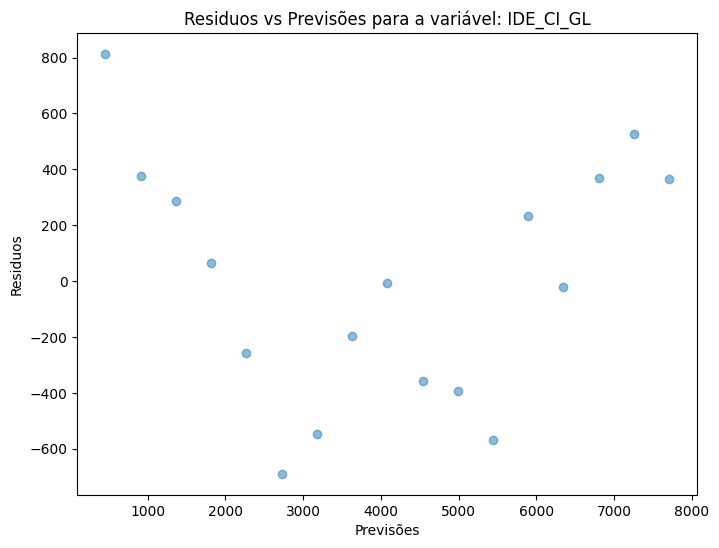

Regressão Linear para 'PERC_JURO':
                            OLS Regression Results                            
Dep. Variable:              perc_Juro   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1.598
Date:                Mon, 05 Aug 2024   Prob (F-statistic):              0.225
Time:                        00:13:11   Log-Likelihood:                -31.615
No. Observations:                  17   AIC:                             67.23
Df Residuals:                      15   BIC:                             68.90
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        209.

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17


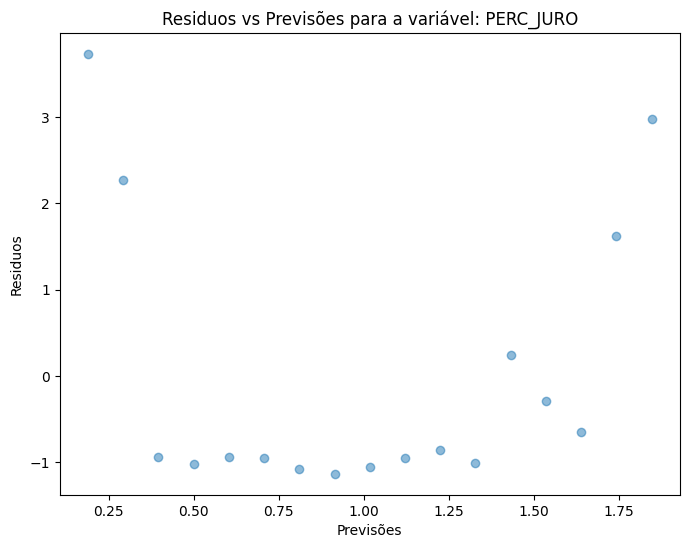

Regressão Linear para 'PERC_AL_H':
                            OLS Regression Results                            
Dep. Variable:              perc_AL_H   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     92.63
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           8.25e-08
Time:                        00:13:12   Log-Likelihood:                -23.019
No. Observations:                  17   AIC:                             50.04
Df Residuals:                      15   BIC:                             51.70
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -955.

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17


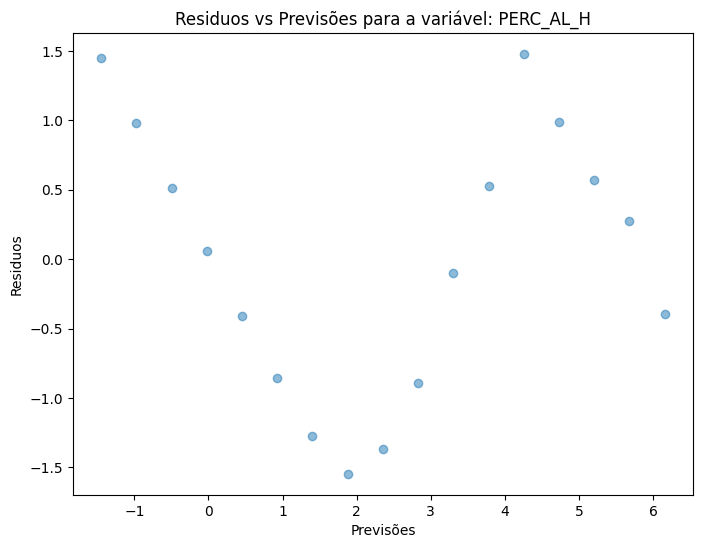

Regressão Linear para 'LOG_PREÇO_M2':
                            OLS Regression Results                            
Dep. Variable:           log_Preço_m2   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     36.85
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           2.14e-05
Time:                        00:13:12   Log-Likelihood:                 4.6616
No. Observations:                  17   AIC:                            -5.323
Df Residuals:                      15   BIC:                            -3.657
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17


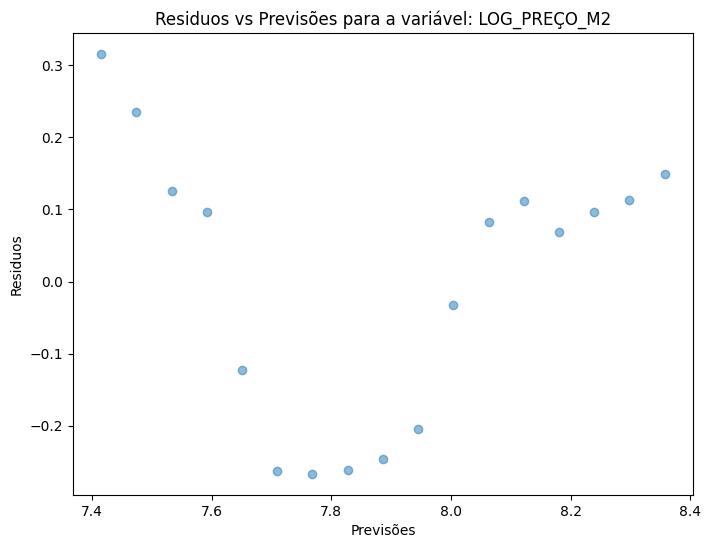

Regressão Linear para 'LOG_N_AL':
                            OLS Regression Results                            
Dep. Variable:               log_N_AL   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     199.2
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           4.57e-10
Time:                        00:13:12   Log-Likelihood:                -17.923
No. Observations:                  17   AIC:                             39.85
Df Residuals:                      15   BIC:                             41.51
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1033.6

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17


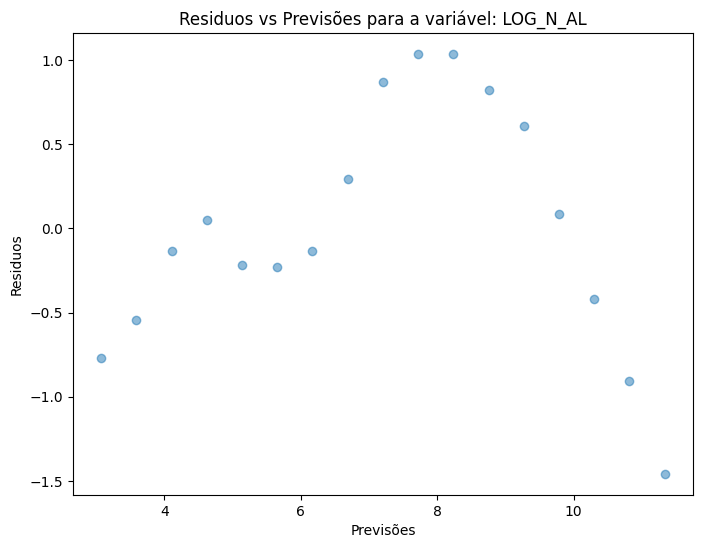

In [16]:
# Lista para armazenar os resultados de regressão
regression_results = []

# Iterar sobre as colunas numéricas, exceto as coluna de anos
for column in df.columns[2:]:  # Ignorando as duas primeiras colunas que se referem aos anos
    # Realizar a regressão linear
    X = sm.add_constant(df['Ano'])  # Adicionar uma coluna de 1s para o termo constante
    y = df[column]
    model = sm.OLS(y, X).fit()
    
    # Adicionar os resultados à nossa lista
    regression_results.append((column, model))

# Agora, vamos imprimir o summary para cada regressão linear e gerar os gráficos de resíduos vs. previsões
for column, model in regression_results:
    print(f"\033[1mRegressão Linear para '{column.upper()}':\033[0m")
    print(model.summary())
    print("="*80)
    
    # Gerar o gráfico de resíduos vs. previsões
    y_pred = model.predict(X)
    residuos = model.resid
    
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuos, alpha=0.5)
    plt.title(f'Residuos vs Previsões para a variável: {column.upper()}')
    plt.xlabel('Previsões')
    plt.ylabel('Residuos')
    plt.show()

### Modelo Exponencial

C:\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17


Regressão Linear para 'LOG_N_AL':
                            OLS Regression Results                            
Dep. Variable:               log_N_AL   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     199.2
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           4.57e-10
Time:                        00:13:13   Log-Likelihood:                -17.923
No. Observations:                  17   AIC:                             39.85
Df Residuals:                      15   BIC:                             41.51
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0

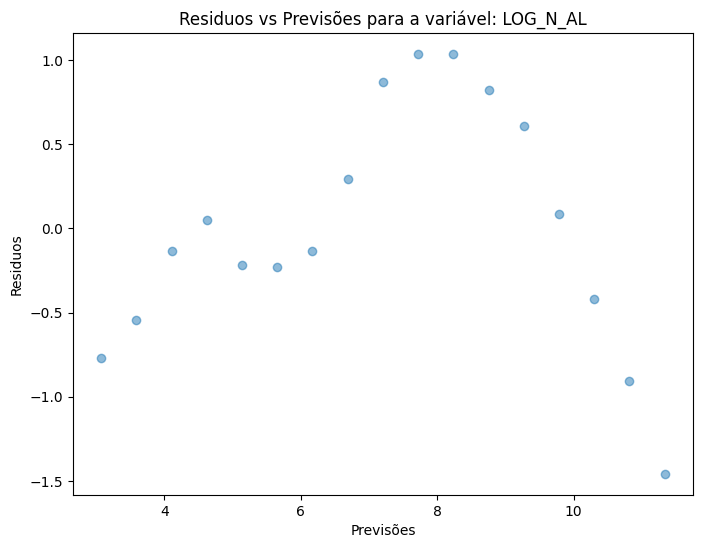

Regressão Linear para 'PREÇO_M2 LOG':
                            OLS Regression Results                            
Dep. Variable:           Preço_m2 log   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     36.85
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           2.14e-05
Time:                        00:13:14   Log-Likelihood:                 4.6616
No. Observations:                  17   AIC:                            -5.323
Df Residuals:                      15   BIC:                            -3.657
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17


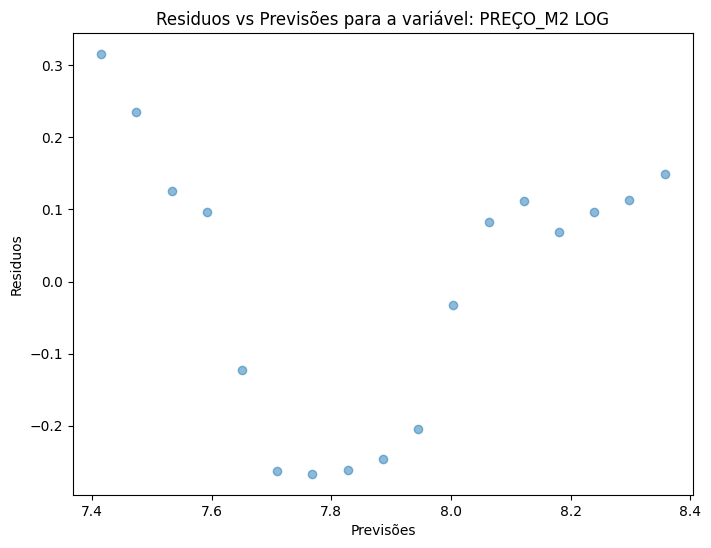

Regressão Linear para 'N_AL LOG':
                            OLS Regression Results                            
Dep. Variable:               N_AL log   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     199.2
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           4.57e-10
Time:                        00:13:14   Log-Likelihood:                -17.923
No. Observations:                  17   AIC:                             39.85
Df Residuals:                      15   BIC:                             41.51
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17


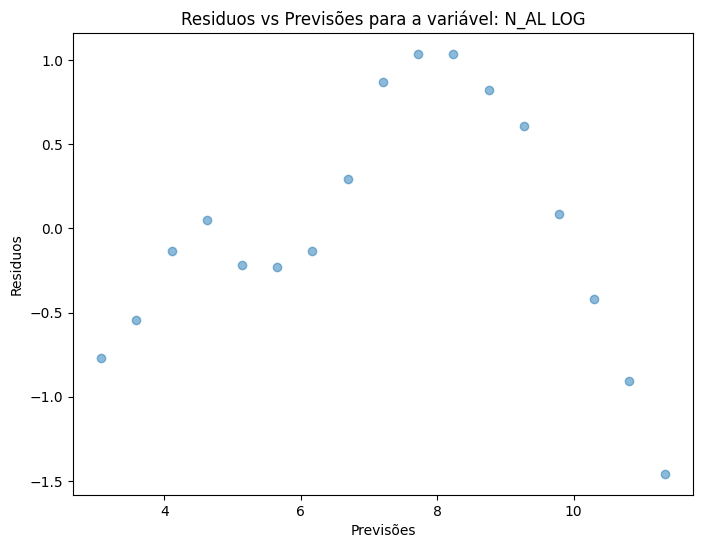

Regressão Linear para 'N_H LOG':
                            OLS Regression Results                            
Dep. Variable:                N_H log   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     3.824
Date:                Mon, 05 Aug 2024   Prob (F-statistic):             0.0694
Time:                        00:13:14   Log-Likelihood:                 51.095
No. Observations:                  17   AIC:                            -98.19
Df Residuals:                      15   BIC:                            -96.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.66

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17


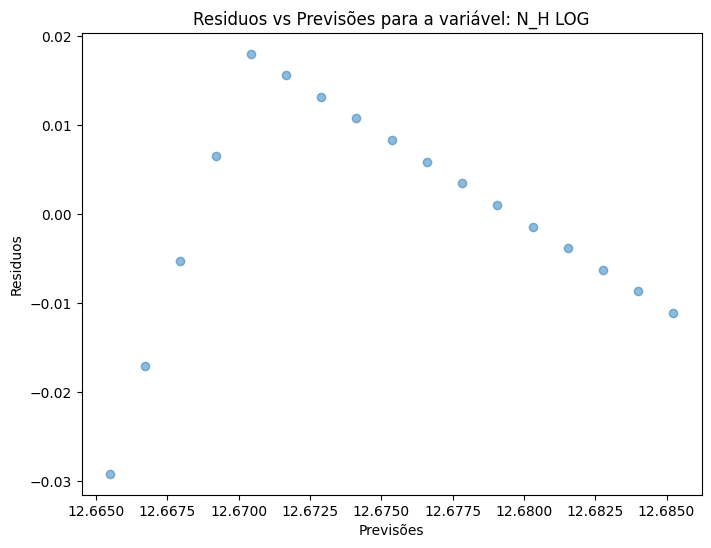

Regressão Linear para 'N_D LOG':
                            OLS Regression Results                            
Dep. Variable:                N_D log   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     4.300
Date:                Mon, 05 Aug 2024   Prob (F-statistic):             0.0558
Time:                        00:13:14   Log-Likelihood:                -7.3252
No. Observations:                  17   AIC:                             18.65
Df Residuals:                      15   BIC:                             20.32
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.68

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17


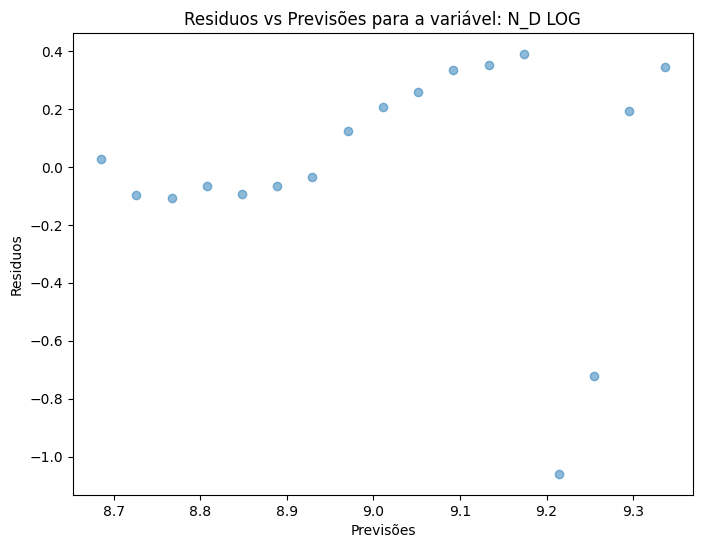

Regressão Linear para 'PIB_AML LOG':
                            OLS Regression Results                            
Dep. Variable:            PIB_AML log   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     21.61
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           0.000315
Time:                        00:13:15   Log-Likelihood:                 20.205
No. Observations:                  17   AIC:                            -36.41
Df Residuals:                      15   BIC:                            -34.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         1

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17


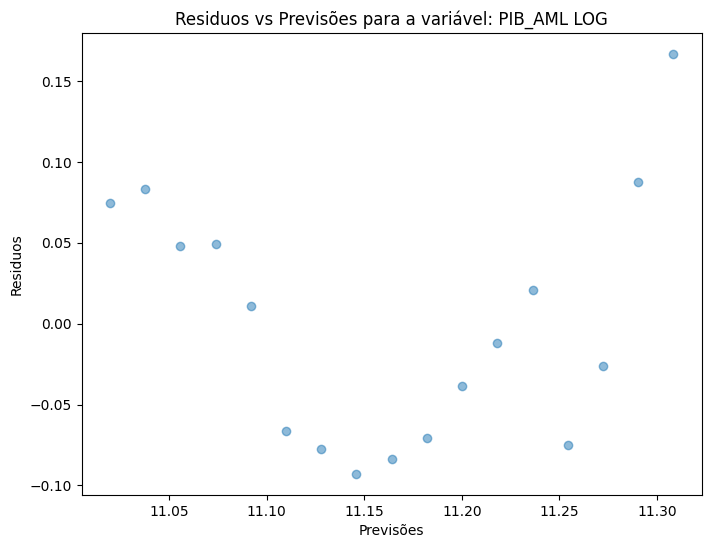

Regressão Linear para 'IDE_CI_GL LOG':
                            OLS Regression Results                            
Dep. Variable:          IDE_CI_GL log   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     791.4
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           2.15e-14
Time:                        00:13:15   Log-Likelihood:                 18.036
No. Observations:                  17   AIC:                            -32.07
Df Residuals:                      15   BIC:                            -30.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17


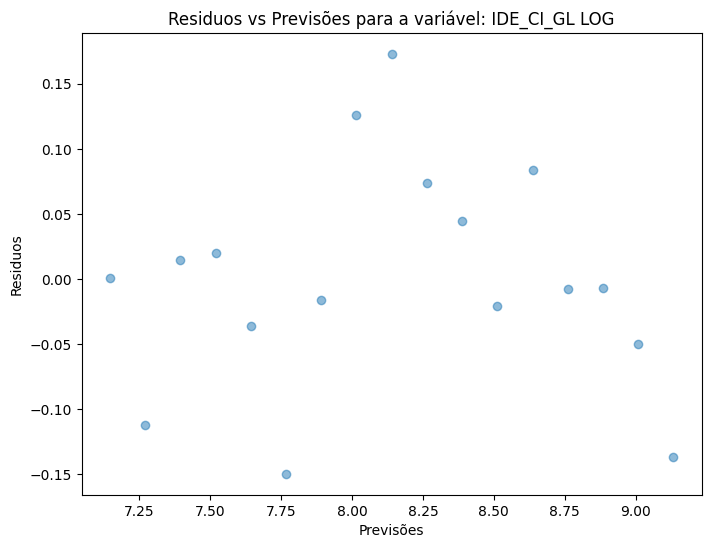

Regressão Linear para 'PERC_JURO LOG':
                            OLS Regression Results                            
Dep. Variable:          perc_Juro log   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 05 Aug 2024   Prob (F-statistic):                nan
Time:                        00:13:15   Log-Likelihood:                    nan
No. Observations:                  17   AIC:                               nan
Df Residuals:                      15   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

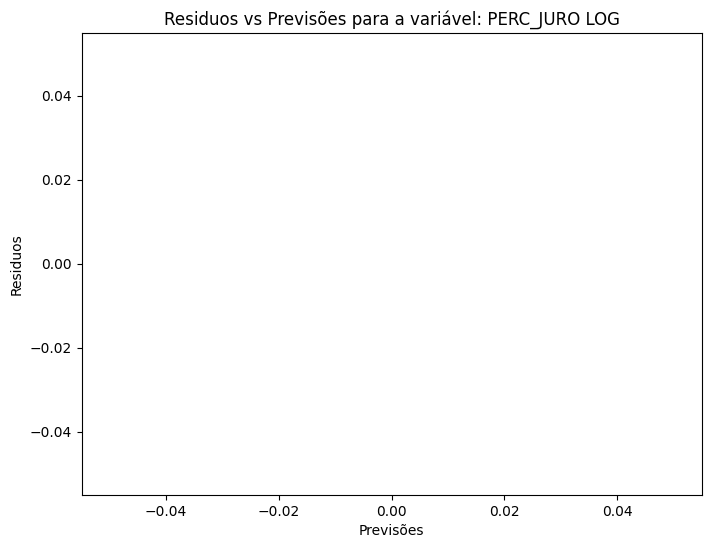

Regressão Linear para 'PERC_AL_H LOG':
                            OLS Regression Results                            
Dep. Variable:          perc_AL_H log   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     196.6
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           5.02e-10
Time:                        00:13:16   Log-Likelihood:                -17.833
No. Observations:                  17   AIC:                             39.67
Df Residuals:                      15   BIC:                             41.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17


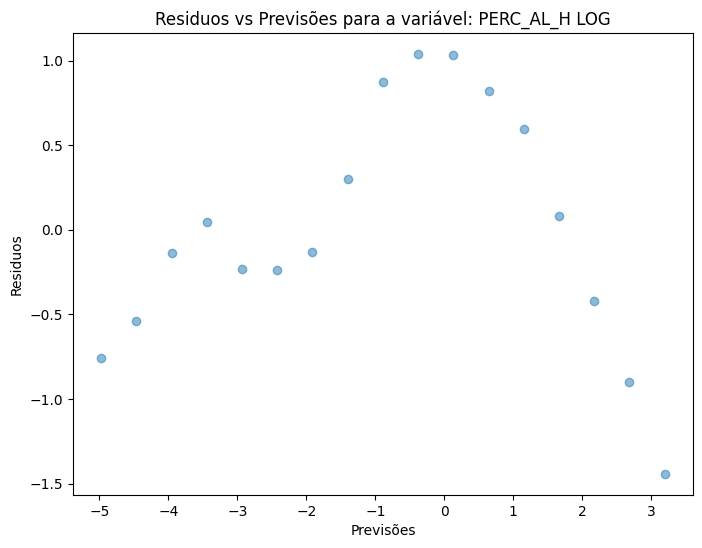

Regressão Linear para 'LOG_PREÇO_M2 LOG':
                            OLS Regression Results                            
Dep. Variable:       log_Preço_m2 log   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     35.89
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           2.47e-05
Time:                        00:13:16   Log-Likelihood:                 39.762
No. Observations:                  17   AIC:                            -75.52
Df Residuals:                      15   BIC:                            -73.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17


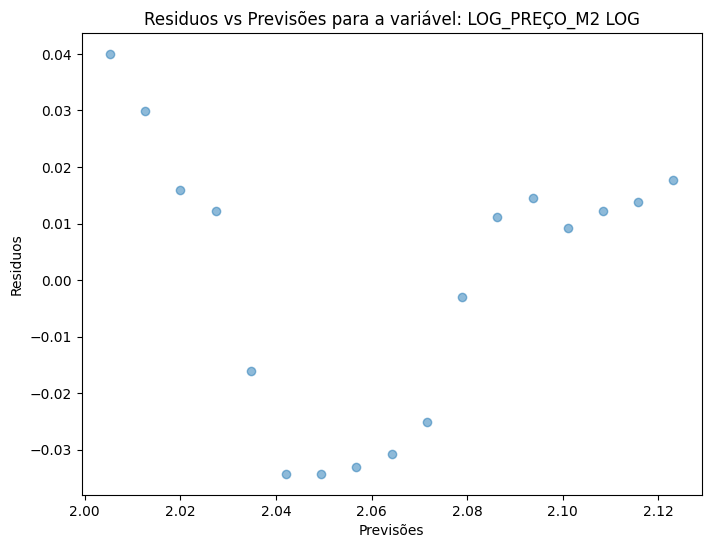

Regressão Linear para 'LOG_N_AL LOG':
                            OLS Regression Results                            
Dep. Variable:           log_N_AL log   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     96.32
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           6.39e-08
Time:                        00:13:16   Log-Likelihood:                 6.5638
No. Observations:                  17   AIC:                            -9.128
Df Residuals:                      15   BIC:                            -7.461
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17


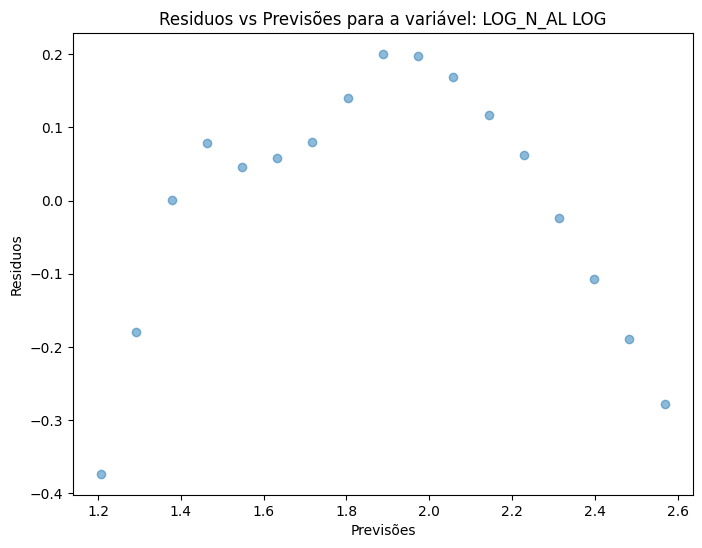

KeyError: 'perc_Juro'

In [17]:
# Supondo que 'df' seja o seu DataFrame com a coluna de anos e as outras colunas numéricas
# Copiar o DataFrame original para manter os dados originais
df_transformed = df.copy()

#Como temos valores negativos na variavel de taxa de juro, vamos sumar a essa variável 0.6
df_transformed["perc_Juro"] = df_transformed["perc_Juro"] + 0.6

for coluna in df_transformed.columns[2:]:  # Começa da terceira coluna em diante
    df_transformed[coluna + ' log'] = np.log(df[coluna])
    
# Select columns that contain the word 'log'
log_columns = [col for col in df_transformed.columns if 'log' in col]
# Add the first column to the list of columns to keep
columns_to_keep = [df_transformed.columns[0]] + log_columns
# Keep only the selected columns
df_transformed = df_transformed[columns_to_keep]

regression_results_a = []

# Iterar sobre as colunas numéricas, exceto a coluna de anos
for column in df_transformed.columns[2:]:  # Ignorando as duas primeira coluna que são de anos
    # Realizar a regressão linear
    X = sm.add_constant(df_transformed['Anos'])  # Adicionar uma coluna de 1s para o termo constante
    y = df_transformed[column]
    model = sm.OLS(y, X).fit()
    
    # Adicionar os resultados à nossa lista
    regression_results_a.append((column, model))

# Agora, vamos imprimir o summary para cada regressão linear e gerar os gráficos de resíduos vs. previsões
for column, model in regression_results_a:
    print(f"\033[1mRegressão Linear para '{column.upper()}':\033[0m")
    print(model.summary())
    print("="*80)
    
    # Gerar o gráfico de resíduos vs. previsões
    y_pred = model.predict(X)
    residuos = model.resid
    
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuos, alpha=0.5)
    plt.title(f'Residuos vs Previsões para a variável: {column.upper()}')
    plt.xlabel('Previsões')
    plt.ylabel('Residuos')
    plt.show()

df_transformed["perc_Juro"] = df_transformed["perc_Juro"] - 0.6

Vamos escolher Linear para todas pois:

- é um modelo mais simples e mais intuitivo
- a diferença no R2 para a exponencial é reduzida

# Aplicar Variações (Diferenças)

In [18]:
df

,Anos,Ano,Preço_m2,N_AL,N_H,N_D,PIB_AML,IDE_CI_GL,perc_Juro,perc_AL_H,log_Preço_m2,log_N_AL
0,0,2007,2279,10,307534,6076,65807,1271,4.82,0.00,7.73,2.30
1,1,2008,2230,21,311646,5588,67581,1285,3.37,0.01,7.71,3.04
2,2,2009,2119,53,315757,5772,66436,1651,1.00,0.02,7.66,3.97
3,3,2010,2182,107,319869,6252,67732,1880,1.25,0.03,7.69,4.67
4,4,2011,1860,137,323981,6355,66343,2013,1.67,0.04,7.53,4.92
5,5,2012,1715,227,323597,6789,62528,2034,0.32,0.07,7.45,5.42
6,6,2013,1812,420,323213,7310,62955,2631,0.37,0.13,7.50,6.04
7,7,2014,1933,1077,322829,8918,63145,3434,0.18,0.33,7.57,6.98
8,8,2015,2079,3213,322445,10099,64897,4077,-0.04,0.99,7.64,8.07
9,9,2016,2300,6367,322062,11066,66942,4180,-0.22,1.94,7.74,8.76


In [19]:
# Calcular a diferença para todas as colunas, exceto as duas primeiras
df_diff = df.iloc[:, 2:].diff()
df_diff = df_diff.drop(0)
# Renomear a coluna adicionando a palavra "dif_" antes do nome
df_diff.rename(columns=lambda x: 'dif_' + x, inplace=True)
df_diff

,dif_Preço_m2,dif_N_AL,dif_N_H,dif_N_D,dif_PIB_AML,dif_IDE_CI_GL,dif_perc_Juro,dif_perc_AL_H,dif_log_Preço_m2,dif_log_N_AL
1,-49.00,11.00,4112.00,-488.00,1774.00,14.00,-1.45,0.00,-0.02,0.74
2,-111.00,32.00,4111.00,184.00,-1145.00,366.00,-2.37,0.01,-0.05,0.93
3,63.00,54.00,4112.00,480.00,1296.00,229.00,0.25,0.02,0.03,0.70
4,-322.00,30.00,4112.00,103.00,-1389.00,133.00,0.42,0.01,-0.16,0.25
5,-145.00,90.00,-384.00,434.00,-3815.00,21.00,-1.35,0.03,-0.08,0.50
6,97.00,193.00,-384.00,521.00,427.00,597.00,0.05,0.06,0.06,0.62
7,121.00,657.00,-384.00,1608.00,190.00,803.00,-0.19,0.20,0.06,0.94
8,146.00,2136.00,-384.00,1181.00,1752.00,643.00,-0.22,0.65,0.07,1.09
9,221.00,3154.00,-383.00,967.00,2045.00,103.00,-0.18,0.95,0.10,0.68
10,599.00,4288.00,-384.00,1361.00,3417.00,416.00,-0.05,1.27,0.23,0.51


# 8. Gráfico Temporal para cada variável

C:\Users\p5768\AppData\Local\Temp\ipykernel_8548\3676399335.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


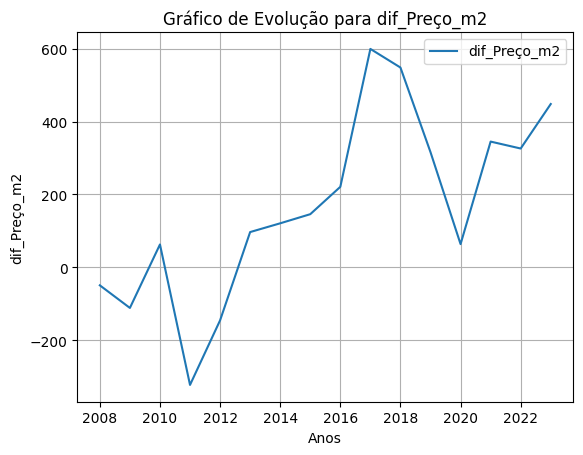

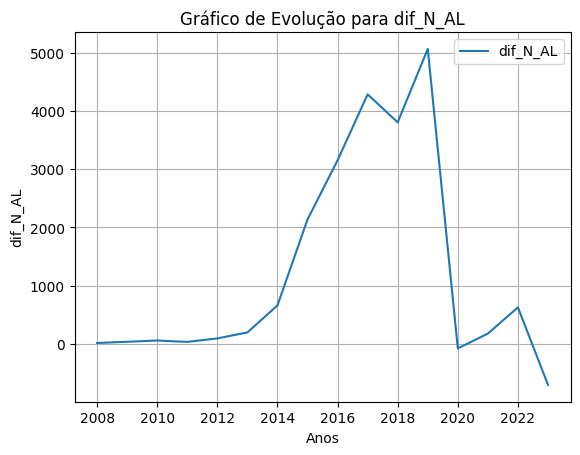

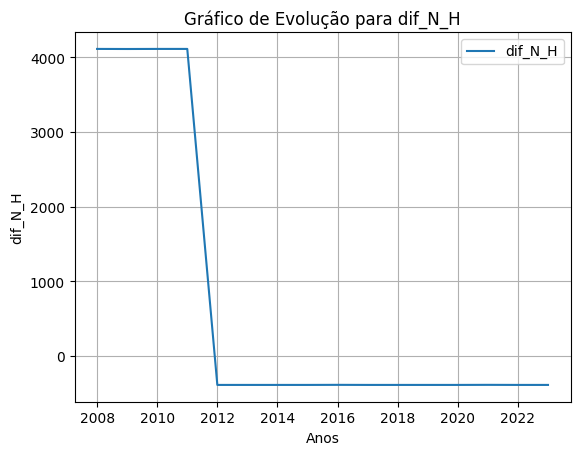

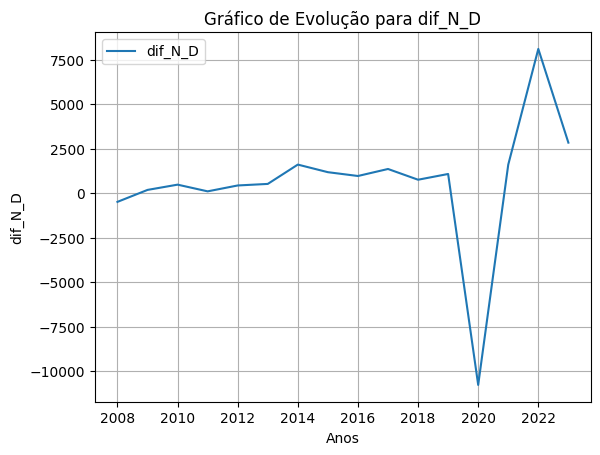

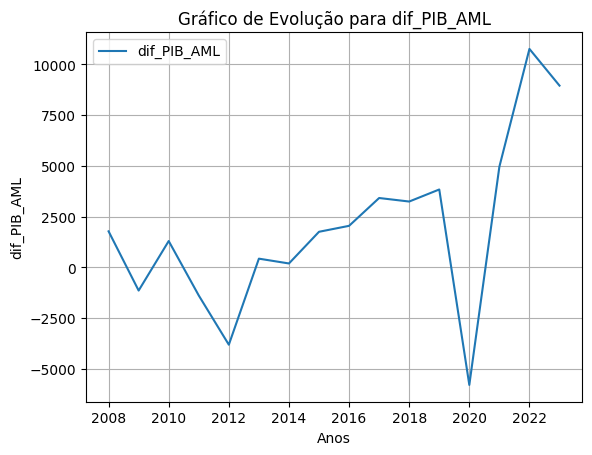

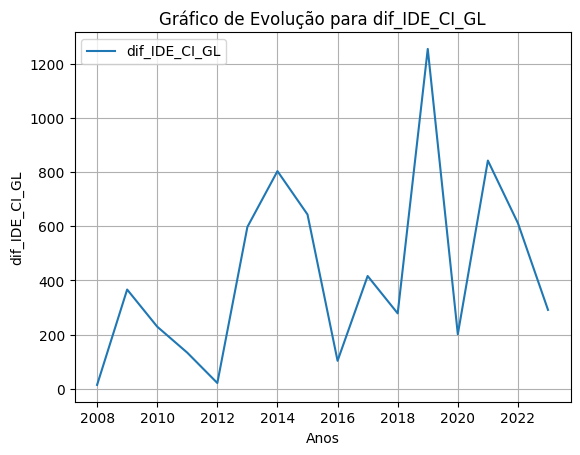

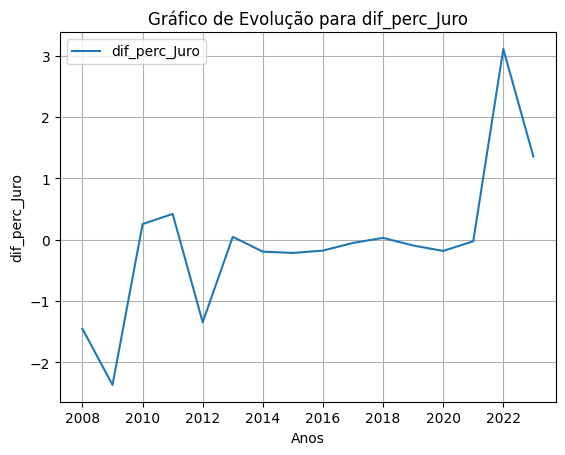

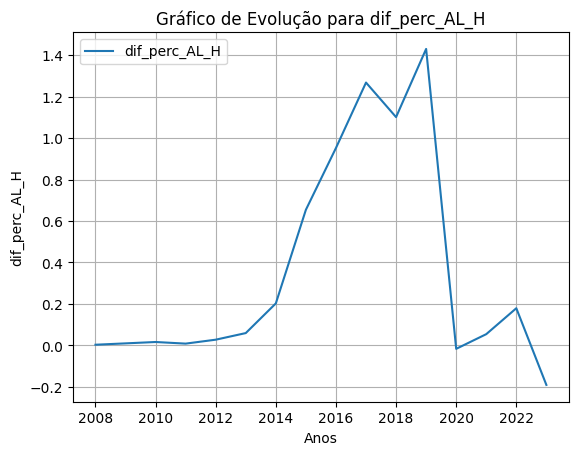

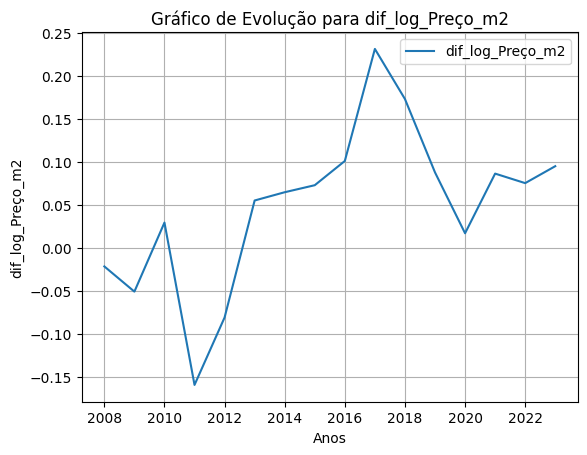

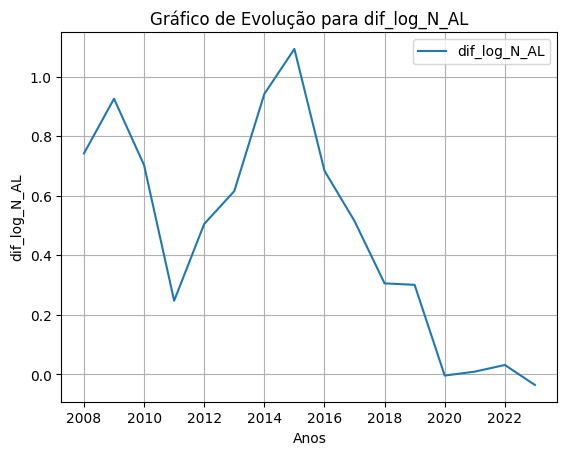

In [20]:
# Adicionar uma nova coluna 'Anos' que vai de 2008 a 2023
df_diff['Anos'] = pd.date_range(start='2008', end='2024', freq='Y').year
# Colocar a coluna 'Anos' como a primeira coluna
df_diff.insert(0, 'Anos', df_diff.pop('Anos'))
# Definir a coluna 'Anos' como o índice do DataFrame
df_diff.set_index('Anos', inplace=True)

# Plotar um gráfico de evolução para cada variável
for column in df_diff.columns:
    plt.plot(df_diff.index, df_diff[column], label=column)

    # Personalizar rótulos e título para cada variável
    plt.xlabel('Anos')
    plt.ylabel(f'{column}')
    plt.title(f'Gráfico de Evolução para {column}')
    plt.legend()  # Adicionar legenda
    plt.grid(True)  # Adicionar grade
    plt.show()

# 9. Calcular para cada variável a média e desvio padrão

In [21]:
# Calcular as estatísticas resumidas para todas as colunas do DataFrame
summary_stats = df_diff.describe().T
# Adicionar o nome das colunas como uma nova coluna 'Nome da Coluna'
summary_stats['Nome da Coluna'] = summary_stats.index
# Reordenar as colunas para que 'Nome da Coluna' seja a primeira coluna
summary_stats = summary_stats[['min', 'max', 'mean', 'std']]
# Renomear as colunas para que fiquem mais claras
summary_stats.rename(columns={'min': 'Mínimo', 'max': 'Máximo', 'mean': 'Média', 'std': 'Desvio Padrão'}, inplace=True)
# Exibir a tabela de estatísticas resumidas
summary_stats

,Mínimo,Máximo,Média,Desvio Padrão
dif_Preço_m2,-322.00,599.00,166.69,255.88
dif_N_AL,-710.00,5069.00,1220.31,1837.81
dif_N_H,-384.00,4112.00,740.06,2010.49
dif_N_D,-10783.00,8113.00,622.88,3614.99
dif_PIB_AML,-5797.00,10766.00,1907.38,4188.39
dif_IDE_CI_GL,14.00,1254.00,425.12,343.37
dif_perc_Juro,-2.37,3.11,-0.06,1.20
dif_perc_AL_H,-0.19,1.43,0.36,0.53
dif_log_Preço_m2,-0.16,0.23,0.05,0.09
dif_log_N_AL,-0.04,1.09,0.47,0.37


# Calcular as regressões com ∆Y = dif_Preço_m2 e ∆𝑋 = dif_N_AL

### ∆𝑌 = 𝛼 + 𝛽 ∆𝑋

In [22]:
df_diff

,dif_Preço_m2,dif_N_AL,dif_N_H,dif_N_D,dif_PIB_AML,dif_IDE_CI_GL,dif_perc_Juro,dif_perc_AL_H,dif_log_Preço_m2,dif_log_N_AL
Anos,,,,,,,,,,
2008,-49.00,11.00,4112.00,-488.00,1774.00,14.00,-1.45,0.00,-0.02,0.74
2009,-111.00,32.00,4111.00,184.00,-1145.00,366.00,-2.37,0.01,-0.05,0.93
2010,63.00,54.00,4112.00,480.00,1296.00,229.00,0.25,0.02,0.03,0.70
2011,-322.00,30.00,4112.00,103.00,-1389.00,133.00,0.42,0.01,-0.16,0.25
2012,-145.00,90.00,-384.00,434.00,-3815.00,21.00,-1.35,0.03,-0.08,0.50
2013,97.00,193.00,-384.00,521.00,427.00,597.00,0.05,0.06,0.06,0.62
2014,121.00,657.00,-384.00,1608.00,190.00,803.00,-0.19,0.20,0.06,0.94
2015,146.00,2136.00,-384.00,1181.00,1752.00,643.00,-0.22,0.65,0.07,1.09
2016,221.00,3154.00,-383.00,967.00,2045.00,103.00,-0.18,0.95,0.10,0.68


Esta referência sugere que maxlags seja igual a N^(1/4), ou seja, 2

https://stats.stackexchange.com/questions/174149/how-to-determine-the-appropriate-number-of-lags-when-using-newey-west-or-hac-s

In [23]:

reg1 = smf.ols("dif_Preço_m2 ~ dif_N_AL", data=df_diff).fit()

# Print out the statistics
print(reg1.get_robustcov_results(cov_type="HAC", maxlags=2).summary())

                            OLS Regression Results                            
Dep. Variable:           dif_Preço_m2   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     6.887
Date:                Mon, 05 Aug 2024   Prob (F-statistic):             0.0200
Time:                        00:13:41   Log-Likelihood:                -107.75
No. Observations:                  16   AIC:                             219.5
Df Residuals:                      14   BIC:                             221.0
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     69.7399     95.349      0.731      0.4

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16


### ∆𝑌 = 𝛼 + 𝛽0∆𝑋t + 𝛽1∆𝑋t-1

In [24]:

reg2 = smf.ols("dif_Preço_m2 ~ dif_N_AL + dif_N_AL.shift(1)", data=df_diff).fit()

# Print out the statistics
print(reg2.get_robustcov_results(cov_type="HAC", maxlags=2).summary())

                            OLS Regression Results                            
Dep. Variable:           dif_Preço_m2   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     3.337
Date:                Mon, 05 Aug 2024   Prob (F-statistic):             0.0704
Time:                        00:13:46   Log-Likelihood:                -101.13
No. Observations:                  15   AIC:                             208.3
Df Residuals:                      12   BIC:                             210.4
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            68.6484    106.35

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15


### Regressão Completa (com variáveis de confusão)

In [25]:
reg3 = smf.ols("dif_Preço_m2 ~ dif_N_AL + dif_N_H  + dif_N_D + dif_PIB_AML + dif_IDE_CI_GL + dif_perc_Juro", data=df_diff).fit()

# Print out the statistics
print(reg3.get_robustcov_results(cov_type="HAC", maxlags=2).summary())

                            OLS Regression Results                            
Dep. Variable:           dif_Preço_m2   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     64.40
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           6.97e-07
Time:                        00:13:49   Log-Likelihood:                -94.878
No. Observations:                  16   AIC:                             203.8
Df Residuals:                       9   BIC:                             209.2
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        79.1443     44.981      1.759

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16


In [26]:
reg4 = smf.ols("dif_Preço_m2 ~ dif_N_AL + dif_N_H  + dif_N_D + dif_PIB_AML + dif_IDE_CI_GL + dif_perc_Juro + dif_N_AL.shift(1)", data=df_diff).fit()
 
# Print out the statistics
print(reg4.get_robustcov_results(cov_type="HAC", maxlags=2).summary())

                            OLS Regression Results                            
Dep. Variable:           dif_Preço_m2   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     52.82
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           1.57e-05
Time:                        00:13:52   Log-Likelihood:                -88.090
No. Observations:                  15   AIC:                             192.2
Df Residuals:                       7   BIC:                             197.8
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            64.4315     58.39

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15


In [28]:
stargazer = Stargazer([reg1, reg2, reg3, reg4])
stargazer.covariate_order(["dif_N_AL", "Intercept","dif_N_AL.shift(1)","dif_N_H","dif_N_D","dif_PIB_AML","dif_IDE_CI_GL","dif_perc_Juro"])
stargazer


# Calcular as regressões com ∆Y = dif_Preço_m2 e ∆𝑋 = dif_perc_AL_H

In [58]:
reg1 = smf.ols("dif_Preço_m2 ~ dif_perc_AL_H", data=df_diff).fit()

# Print out the statistics
print(reg1.get_robustcov_results(cov_type="HAC", maxlags=2).summary())

                            OLS Regression Results                            
Dep. Variable:           dif_Preço_m2   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     7.158
Date:                Mon, 05 Aug 2024   Prob (F-statistic):             0.0181
Time:                        00:39:16   Log-Likelihood:                -107.69
No. Observations:                  16   AIC:                             219.4
Df Residuals:                      14   BIC:                             220.9
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        66.9826     95.696      0.700

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16


In [59]:
reg2 = smf.ols("dif_Preço_m2 ~ dif_perc_AL_H + dif_perc_AL_H.shift(1)", data=df_diff).fit()

# Print out the statistics
print(reg2.get_robustcov_results(cov_type="HAC", maxlags=2).summary())

                            OLS Regression Results                            
Dep. Variable:           dif_Preço_m2   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     3.428
Date:                Mon, 05 Aug 2024   Prob (F-statistic):             0.0664
Time:                        00:39:17   Log-Likelihood:                -101.05
No. Observations:                  15   AIC:                             208.1
Df Residuals:                      12   BIC:                             210.2
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 65

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15


In [60]:
reg3 = smf.ols("dif_Preço_m2 ~ dif_perc_AL_H + dif_N_H  + dif_N_D + dif_PIB_AML + dif_IDE_CI_GL + dif_perc_Juro", data=df_diff).fit()

# Print out the statistics
print(reg3.get_robustcov_results(cov_type="HAC", maxlags=2).summary())

                            OLS Regression Results                            
Dep. Variable:           dif_Preço_m2   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     67.94
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           5.52e-07
Time:                        00:39:19   Log-Likelihood:                -94.830
No. Observations:                  16   AIC:                             203.7
Df Residuals:                       9   BIC:                             209.1
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        75.3783     43.889      1.717

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16


In [61]:
reg4 = smf.ols("dif_Preço_m2 ~ dif_perc_AL_H + dif_N_H  + dif_N_D + dif_PIB_AML + dif_IDE_CI_GL + dif_perc_Juro + dif_perc_AL_H.shift(1)", data=df_diff).fit()
 
# Print out the statistics
print(reg4.get_robustcov_results(cov_type="HAC", maxlags=2).summary())

                            OLS Regression Results                            
Dep. Variable:           dif_Preço_m2   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     52.15
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           1.64e-05
Time:                        00:39:21   Log-Likelihood:                -87.985
No. Observations:                  15   AIC:                             192.0
Df Residuals:                       7   BIC:                             197.6
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 57

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15


In [62]:
stargazer = Stargazer([reg1, reg2, reg3, reg4])
stargazer.covariate_order(["dif_perc_AL_H", "Intercept","dif_perc_AL_H.shift(1)","dif_N_H","dif_N_D","dif_PIB_AML","dif_IDE_CI_GL","dif_perc_Juro"])
stargazer

# Calcular as regressões com ∆Y = dif_log_Preço_m2 e ∆𝑋 = dif_N_AL

In [63]:
reg1 = smf.ols("dif_log_Preço_m2 ~ dif_N_AL", data=df_diff).fit()

# Print out the statistics
print(reg1.get_robustcov_results(cov_type="HAC", maxlags=2).summary())

                            OLS Regression Results                            
Dep. Variable:       dif_log_Preço_m2   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     9.565
Date:                Mon, 05 Aug 2024   Prob (F-statistic):            0.00795
Time:                        00:40:50   Log-Likelihood:                 19.627
No. Observations:                  16   AIC:                            -35.25
Df Residuals:                      14   BIC:                            -33.71
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0085      0.029      0.292      0.7

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16


In [64]:
reg2 = smf.ols("dif_log_Preço_m2 ~ dif_N_AL + dif_N_AL.shift(1)", data=df_diff).fit()

# Print out the statistics
print(reg2.get_robustcov_results(cov_type="HAC", maxlags=2).summary())

                            OLS Regression Results                            
Dep. Variable:       dif_log_Preço_m2   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     5.729
Date:                Mon, 05 Aug 2024   Prob (F-statistic):             0.0179
Time:                        00:40:52   Log-Likelihood:                 18.127
No. Observations:                  15   AIC:                            -30.25
Df Residuals:                      12   BIC:                            -28.13
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0080      0.03

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15


In [65]:
reg3 = smf.ols("dif_log_Preço_m2 ~ dif_N_AL + dif_N_H  + dif_N_D + dif_PIB_AML + dif_IDE_CI_GL + dif_perc_Juro", data=df_diff).fit()

# Print out the statistics
print(reg3.get_robustcov_results(cov_type="HAC", maxlags=2).summary())

                            OLS Regression Results                            
Dep. Variable:       dif_log_Preço_m2   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     17.79
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           0.000160
Time:                        00:40:53   Log-Likelihood:                 27.189
No. Observations:                  16   AIC:                            -40.38
Df Residuals:                       9   BIC:                            -34.97
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0161      0.027      0.603

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16


In [66]:
reg4 = smf.ols("dif_log_Preço_m2 ~ dif_N_AL + dif_N_H  + dif_N_D + dif_PIB_AML + dif_IDE_CI_GL + dif_perc_Juro + dif_N_AL.shift(1)", data=df_diff).fit()
 
# Print out the statistics
print(reg4.get_robustcov_results(cov_type="HAC", maxlags=2).summary())

                            OLS Regression Results                            
Dep. Variable:       dif_log_Preço_m2   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     30.79
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           9.66e-05
Time:                        00:40:54   Log-Likelihood:                 25.381
No. Observations:                  15   AIC:                            -34.76
Df Residuals:                       7   BIC:                            -29.10
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0285      0.02

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15


In [67]:
stargazer = Stargazer([reg1, reg2, reg3, reg4])
stargazer.significant_digits(6)
stargazer.covariate_order(["dif_N_AL", "Intercept","dif_N_AL.shift(1)","dif_N_H","dif_N_D","dif_PIB_AML","dif_IDE_CI_GL","dif_perc_Juro"])
stargazer

# Calcular as regressões com ∆Y = dif_log_Preço_m2 e ∆𝑋 = dif_perc_AL_H

In [68]:
reg1 = smf.ols("dif_log_Preço_m2 ~ dif_perc_AL_H", data=df_diff).fit()

# Print out the statistics
print(reg1.get_robustcov_results(cov_type="HAC", maxlags=2).summary())

                            OLS Regression Results                            
Dep. Variable:       dif_log_Preço_m2   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     10.41
Date:                Mon, 05 Aug 2024   Prob (F-statistic):            0.00608
Time:                        00:41:13   Log-Likelihood:                 19.784
No. Observations:                  16   AIC:                            -35.57
Df Residuals:                      14   BIC:                            -34.02
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0071      0.029      0.244

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16


In [69]:
reg2 = smf.ols("dif_log_Preço_m2 ~ dif_perc_AL_H + dif_perc_AL_H.shift(1)", data=df_diff).fit()

# Print out the statistics
print(reg2.get_robustcov_results(cov_type="HAC", maxlags=2).summary())

                            OLS Regression Results                            
Dep. Variable:       dif_log_Preço_m2   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     6.263
Date:                Mon, 05 Aug 2024   Prob (F-statistic):             0.0137
Time:                        00:41:14   Log-Likelihood:                 18.280
No. Observations:                  15   AIC:                            -30.56
Df Residuals:                      12   BIC:                            -28.44
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15


In [70]:
reg3 = smf.ols("dif_log_Preço_m2 ~ dif_perc_AL_H + dif_N_H  + dif_N_D + dif_PIB_AML + dif_IDE_CI_GL + dif_perc_Juro", data=df_diff).fit()

# Print out the statistics
print(reg3.get_robustcov_results(cov_type="HAC", maxlags=2).summary())

                            OLS Regression Results                            
Dep. Variable:       dif_log_Preço_m2   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     19.04
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           0.000122
Time:                        00:41:15   Log-Likelihood:                 27.354
No. Observations:                  16   AIC:                            -40.71
Df Residuals:                       9   BIC:                            -35.30
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0141      0.026      0.541

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16


In [71]:
reg4 = smf.ols("dif_log_Preço_m2 ~ dif_perc_AL_H + dif_N_H  + dif_N_D + dif_PIB_AML + dif_IDE_CI_GL + dif_perc_Juro + dif_perc_AL_H.shift(1)", data=df_diff).fit()
 
# Print out the statistics
print(reg4.get_robustcov_results(cov_type="HAC", maxlags=2).summary())

                            OLS Regression Results                            
Dep. Variable:       dif_log_Preço_m2   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     32.28
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           8.26e-05
Time:                        00:41:16   Log-Likelihood:                 25.486
No. Observations:                  15   AIC:                            -34.97
Df Residuals:                       7   BIC:                            -29.31
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15


In [72]:
stargazer = Stargazer([reg1, reg2, reg3, reg4])
stargazer.covariate_order(["dif_perc_AL_H", "Intercept","dif_perc_AL_H.shift(1)","dif_N_H","dif_N_D","dif_PIB_AML","dif_IDE_CI_GL","dif_perc_Juro"])
stargazer

# Calcular as regressões com ∆Y = dif_log_Preço_m2 e ∆𝑋 = dif_log_N_AL

In [73]:
reg1 = smf.ols("dif_log_Preço_m2 ~ dif_log_N_AL", data=df_diff).fit()

# Print out the statistics
print(reg1.get_robustcov_results(cov_type="HAC", maxlags=2).summary())

                            OLS Regression Results                            
Dep. Variable:       dif_log_Preço_m2   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.062
Method:                 Least Squares   F-statistic:                    0.3625
Date:                Mon, 05 Aug 2024   Prob (F-statistic):              0.557
Time:                        00:43:48   Log-Likelihood:                 15.576
No. Observations:                  16   AIC:                            -27.15
Df Residuals:                      14   BIC:                            -25.61
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0599      0.037      1.604   

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16


In [74]:
reg2 = smf.ols("dif_log_Preço_m2 ~ dif_log_N_AL + dif_log_N_AL.shift(1)", data=df_diff).fit()

# Print out the statistics
print(reg2.get_robustcov_results(cov_type="HAC", maxlags=2).summary())

                            OLS Regression Results                            
Dep. Variable:       dif_log_Preço_m2   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.163
Method:                 Least Squares   F-statistic:                   0.08921
Date:                Mon, 05 Aug 2024   Prob (F-statistic):              0.915
Time:                        00:43:49   Log-Likelihood:                 14.376
No. Observations:                  15   AIC:                            -22.75
Df Residuals:                      12   BIC:                            -20.63
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.05

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15


In [75]:
reg3 = smf.ols("dif_log_Preço_m2 ~ dif_log_N_AL + dif_N_H  + dif_N_D + dif_PIB_AML + dif_IDE_CI_GL + dif_perc_Juro", data=df_diff).fit()

# Print out the statistics
print(reg3.get_robustcov_results(cov_type="HAC", maxlags=2).summary())

                            OLS Regression Results                            
Dep. Variable:       dif_log_Preço_m2   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     23.88
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           4.80e-05
Time:                        00:43:50   Log-Likelihood:                 26.081
No. Observations:                  16   AIC:                            -38.16
Df Residuals:                       9   BIC:                            -32.75
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0209      0.033     -0.642

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16


In [76]:
reg4 = smf.ols("dif_log_Preço_m2 ~ dif_log_N_AL + dif_N_H  + dif_N_D + dif_PIB_AML + dif_IDE_CI_GL + dif_perc_Juro + dif_log_N_AL.shift(1)", data=df_diff).fit()
 
# Print out the statistics
print(reg4.get_robustcov_results(cov_type="HAC", maxlags=2).summary())

                            OLS Regression Results                            
Dep. Variable:       dif_log_Preço_m2   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     61.08
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           9.58e-06
Time:                        00:43:51   Log-Likelihood:                 26.120
No. Observations:                  15   AIC:                            -36.24
Df Residuals:                       7   BIC:                            -30.58
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.04

C:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15


In [77]:
stargazer = Stargazer([reg1, reg2, reg3, reg4])
stargazer.covariate_order(["dif_log_N_AL", "Intercept","dif_log_N_AL.shift(1)","dif_N_H","dif_N_D","dif_PIB_AML","dif_IDE_CI_GL","dif_perc_Juro"])
stargazer